In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D
import netCDF4
import numpy
import os
import pandas
from PIL import Image
import random
import readline
import scipy
from scipy import fft
from scipy import linalg
from scipy import stats
from scipy.stats import poisson, ttest_ind
import seaborn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import normalize
from statsmodels.tsa.ar_model import AutoReg
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/Output_Files/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_Output_V5.csv')
    ET_DF = Open_File(Diri+Model+'_ET_Output_V5.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V5.csv')
    Time = []
    Start_Time = []
    End_Time = []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Start_Time.append(Datetime(ET_DF["Start Time"][j]))
        End_Time.append(Datetime(ET_DF["End Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["Start Time"] = Start_Time
    ET_DF["End Time"] = End_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    return (New_Time)

In [6]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [10]:
# Define Cyclone Type, Set Shape and Colour Code
SLP_Colours = ['darkviolet', 'mediumvioletred', 'magenta', 'red', 'orangered', \
'darkorange', 'orange', 'gold', 'yellow', 'greenyellow', 'limegreen', 'deepskyblue', 'cyan']
SLP_Bounds = Create_Bins(900,1010,10)
def Cyclone_Type(DF, ET_DF, Storm_List):
# Cyclone Type and Shape Code
    Cyclone_Type = []
    Plot_Shape = []
    for i in range(len(DF["Storm Phase"])):
        if DF["Storm Phase"][i] == "Tropical":
            Plot_Shape.append('o')
        elif DF["Storm Phase"][i] == "Transition":
            Plot_Shape.append('s')
        elif DF["Storm Phase"][i] == "Extratropical":
            Plot_Shape.append('^')
        else:
            print (DF["Storm Type"][i])
    DF["Plot Shape"] = Plot_Shape
#    
# SLP Colour Code
    Plot_Colour = []
    for i in range(len(DF["SLP(hPa)"])):
        for k in range(len(SLP_Colours)):
            if k == 0:
                if DF["SLP(hPa)"][i] <= SLP_Bounds[k]:
                    Plot_Colour.append(SLP_Colours[k])
            elif k != len(SLP_Colours)-1:
                if DF["SLP(hPa)"][i] <= SLP_Bounds[k] and DF["SLP(hPa)"][i] > SLP_Bounds[k-1]:
                    Plot_Colour.append(SLP_Colours[k])
            else:
                if DF["SLP(hPa)"][i] > SLP_Bounds[k-1]:
                    Plot_Colour.append(SLP_Colours[k])
    DF["Plot Colour"] = Plot_Colour
    return (DF)

In [44]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)

In [11]:
Control_Data_Plot = Cyclone_Type(Control_Data, Control_ET, Control_Codes["New Code"])
RCP45_Data_Plot = Cyclone_Type(RCP45_Data, RCP45_ET, RCP45_Codes["New Code"])
RCP85_Data_Plot = Cyclone_Type(RCP85_Data, RCP85_ET, RCP85_Codes["New Code"])

In [12]:
# Create Legend
def Plot_TC_Legend(Loc):
    pyplot.scatter([-728], [-728], c='cyan', marker='o', linewidths=0.8, edgecolors='black', label='Tropical')
    pyplot.scatter([-728], [-728], c='cyan', marker='s', linewidths=0.8, edgecolors='black', label='Transition')
    pyplot.scatter([-728], [-728], c='cyan', marker='^', linewidths=0.8, edgecolors='black', label='Extratropical')
    pyplot.legend(loc=Loc, fontsize=12)

In [13]:
# Plot Cyclone Track
def Plot_Cyclone_Track(Storm_Code, DF, ET_DF, Bounds, Colours, Loc, Trans, Model, Savefig, Figsize):
    DF_Storm = DF[DF['Code'] == Storm_Code].reset_index()
    Lon = numpy.array(DF_Storm['Lon'])
    Lat = numpy.array(DF_Storm['Lat'])
    Plot_Colour = list(DF_Storm['Plot Colour'])
    Plot_Shape = list(DF_Storm['Plot Shape'])
#
# Plotting
    Fig = pyplot.figure(figsize=Figsize)
    Axis = Fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
    Axis.coastlines(linewidth=0.5)
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
    Axis.plot(Lon, Lat, c='black', linewidth=0.5, alpha=0.8)
    for k in range(len(Lon)):
        pyplot.scatter(Lon[k], Lat[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.5, edgecolors='black', s=78)
#
# Add ET Start and ET End Locations
    if Trans == True:
        ET_Storm = ET_DF[ET_DF["Code"] == Storm_Code].reset_index()
        pyplot.scatter(ET_Storm["Start Lon"][0], ET_Storm["Start Lat"][0], marker='s', linewidths=4.8, \
        facecolors='none', edgecolors='black', s=178)
        pyplot.scatter(ET_Storm["End Lon"][0], ET_Storm["End Lat"][0]+0.1, marker='^', linewidths=4.2, \
        facecolors='none', edgecolors='black', s=208)
#
# Formatting
    x_Min = (int(round((numpy.min(Lon)+1.5) / 5)) - 1) * 5
    x_Max = (int(round((numpy.max(Lon)-1.5) / 5)) + 1) * 5
    y_Min = (int(round((numpy.min(Lat)+1.5) / 5)) - 1) * 5
    y_Max = (int(round((numpy.max(Lat)-1.5) / 5)) + 1) * 5
    x_Axis = Create_Bins(x_Min,x_Max,5)
    y_Axis = Create_Bins(y_Min,y_Max,5)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
    Title = str(Model + ': ' + DF_Storm['Code'][0] + ' ' + DF_Storm['Name'][0])
    Axis.set_title(Title, fontsize=16)
    Gridline = Axis.gridlines(crs=ccrs.PlateCarree(), linewidth=0.3, color='silver', linestyle='-')
    Gridline.xlocator = mticker.FixedLocator(x_Axis)
    Gridline.ylocator = mticker.FixedLocator(y_Axis)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("SLP(hPa)", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([0.025, -0.12, 0.95, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', spacing='proportional', \
    cax=Cax, label='SLP(hPa)', shrink=0.7)
    Plot_TC_Legend(Loc)
#
# Save Fig
    if Savefig == True:
        Figname = str(DF_Storm['Code'][0] + '_' + DF_Storm['Name'][0] + '_Track.png')
        Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Storm_Figs_V5/'+Figname, bbox_inches='tight')

In [14]:
# Plot Cyclone SLP
def Plot_Cyclone_SLP(Storm_Code, DF, ET_DF, Bounds, Colours, Loc, Trans, Model, Savefig):
    DF_Storm = DF[DF['Code'] == Storm_Code].reset_index()
    Time = list(DF_Storm['Time(Z)'])
    SLP = numpy.array(DF_Storm['SLP(hPa)'])
    Plot_Colour = list(DF_Storm['Plot Colour'])
    Plot_Shape = list(DF_Storm['Plot Shape'])
#
# Plotting
    Fig = pyplot.figure(figsize=(12,7))
    Axis = Fig.add_subplot(1,1,1)
    Axis.plot(Time, SLP, c='black', linewidth=0.5, alpha=0.8)
    for k in range(len(Time)):
        Axis.scatter(Time[k], SLP[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.8, edgecolors='black', s=78)
#
# Add ET Start and ET End Locations
    if Trans == True:
        ET_Storm = ET_DF[ET_DF["Code"] == Storm_Code].reset_index()
        pyplot.scatter(ET_Storm["Start Time"][0], ET_Storm["Start SLP"][0], marker='s', linewidths=4.8, \
        facecolors='none', edgecolors='black', s=178)
        pyplot.scatter(ET_Storm["End Time"][0], ET_Storm["End SLP"][0]+0.2, marker='^', linewidths=4.2, \
        facecolors='none', edgecolors='black', s=208)
#
# Formatting
    pyplot.xlabel('Time (Z)', fontsize=12)
    pyplot.ylabel('Sea Level Pressure (SLP)', fontsize=12)
    x_Min = Time[0] + datetime.timedelta(hours=-6)
    x_Max = Time[len(Time)-1] + datetime.timedelta(hours=6)
    x_Start = datetime.date(x_Min.year,x_Min.month,x_Min.day) + datetime.timedelta(1)
    x_End = datetime.date(x_Max.year,x_Max.month,x_Max.day) + datetime.timedelta(1)
# Time Axis Based on How Many Datapoints
    if len(Time) < 40:
        x_Axis = pandas.date_range(x_Start,x_End,freq='D')
    elif len(Time) < 80:
        x_Axis = pandas.date_range(x_Start,x_End,freq='2D')
    else:
        x_Axis = pandas.date_range(x_Start,x_End,freq='3D')
    y_Min = (int(round(numpy.min(SLP) / 5)) - 1) * 5
    y_Max = (int(round(numpy.max(SLP) / 5)) + 1) * 5
    if y_Max - y_Min < 60:
        y_Axis = Create_Bins(y_Min,y_Max,5)
    else:
        if y_Min % 10 == 0:
            y_Axis = Create_Bins(y_Min,y_Max,10)
        else:
            y_Axis = Create_Bins(y_Min-5,y_Max+5,5)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
    Title = str(Model + ': ' + DF_Storm['Code'][0] + ' ' + DF_Storm['Name'][0])
    Axis.set_title(Title, fontsize=16)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    Plot_TC_Legend(Loc)
#
# Save Fig
    if Savefig == True:
        Figname = str(DF_Storm['Code'][0] + '_' + DF_Storm['Name'][0] + '_SLP.png')
        Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Storm_Figs_V5/'+Figname, bbox_inches='tight')

In [15]:
# Plot Cyclone Phase Diagram
def Plot_Cyclone_Phase(Storm_Code, DF, ET_DF, Bounds, Colours, Loc, Trans, Model, Savefig):
    DF_Storm = DF[DF['Code'] == Storm_Code].reset_index()
    VLT = numpy.array(DF_Storm['VLT'])[1:]
    VUT = numpy.array(DF_Storm['VUT'])[1:]
    B = numpy.array(DF_Storm['B'])[1:]
    Plot_Colour = list(DF_Storm['Plot Colour'])[1:]
    Plot_Shape = list(DF_Storm['Plot Shape'])[1:]
#
# Plotting VUT VLT
    Fig = pyplot.figure(figsize=(16,8))
    Axis = Fig.add_subplot(1,2,1)
    x_Axis = Create_Bins(-500,500,100)
    y_Axis = Create_Bins(-30,120,10)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-500,500)
    pyplot.ylim(-30,120)
    pyplot.fill_between([0,500], 15, 120, color='violet', alpha=0.2)
    pyplot.fill_between([-500,0], 15, 120, color='mediumblue', alpha=0.2)
    pyplot.fill_between([0,500], -30, 15, color='red', alpha=0.2)
    pyplot.fill_between([-500,0], -30, 15, color='darkgrey', alpha=0.2)
    pyplot.plot([-500,500], [15,15], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-30,120], 'black', linewidth=0.5)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('B', fontsize=12)
    Axis.plot(VLT, B, c='black', linewidth=0.5, alpha=0.5)
    for k in range(len(VLT)):
        Axis.scatter(VLT[k], B[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.5, edgecolors='black', s=78)
#
# Add ET Start and ET End Locations
    if Trans == True:
        ET_Storm = ET_DF[ET_DF["Code"] == Storm_Code].reset_index()
        Start_Time = ET_Storm["Start Time"][0]
        End_Time = ET_Storm["End Time"][0]
        Start_DF = DF_Storm[DF_Storm["Time(Z)"] == Start_Time]
        End_DF = DF_Storm[DF_Storm["Time(Z)"] == End_Time]
#        print (Start_DF)
        pyplot.scatter(Start_DF["VLT"], Start_DF["B"], marker='s', linewidths=4.8, \
        facecolors='none', edgecolors='black', s=178)
        pyplot.scatter(End_DF["VLT"], End_DF["B"]+0.5, marker='^', linewidths=4.2, \
        facecolors='none', edgecolors='black', s=208)
    Title = str(Model + ': ' + DF_Storm['Code'][0] + ' ' + DF_Storm['Name'][0])
    Axis.set_title(Title, fontsize=18)
    Plot_TC_Legend(Loc)
#
# Plotting VUT VLT
    Axis = Fig.add_subplot(1,2,2)
    x_Axis = Create_Bins(-500,500,100)
    y_Axis = Create_Bins(-500,500,100)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-500,500)
    pyplot.ylim(-500,500)
    pyplot.fill_between([0,500], 500, color='red', alpha=0.2)
    pyplot.fill_between([-500,0], 500, color='lightskyblue', alpha=0.2)
    pyplot.fill_between([0,500], -500, color='orangered', alpha=0.2)
    pyplot.fill_between([-500,0], -500, color='mediumblue', alpha=0.2)
    pyplot.plot([-500,500], [0,0], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-500,500], 'black', linewidth=0.5)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('VUT', fontsize=12)
    Axis.plot(VLT, VUT, c='black', linewidth=0.5, alpha=0.5)
    for k in range(len(VLT)):
        Axis.scatter(VLT[k], VUT[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.5, edgecolors='black', s=78)
    if Trans == True:
        ET_Storm = ET_DF[ET_DF["Code"] == Storm_Code].reset_index()
        Start_Time = ET_Storm["Start Time"][0]
        End_Time = ET_Storm["End Time"][0]
        Start_DF = DF_Storm[DF_Storm["Time(Z)"] == Start_Time]
        End_DF = DF_Storm[DF_Storm["Time(Z)"] == End_Time]
        pyplot.scatter(Start_DF["VLT"], Start_DF["VUT"], marker='s', linewidths=4.8, \
        facecolors='none', edgecolors='black', s=178)
        pyplot.scatter(End_DF["VLT"], End_DF["VUT"]+0.5, marker='^', linewidths=4.2, \
        facecolors='none', edgecolors='black', s=208)
    Axis.set_title(Title, fontsize=18)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("SLP(hPa)", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([-0.75, -0.15, 1.3, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', spacing='proportional', \
    cax=Cax, label='SLP(hPa)', shrink=0.7)
#
# Save Fig
    if Savefig == True:
        Figname = str(DF_Storm['Code'][0] + '_' + DF_Storm['Name'][0] + '_Phase.png')
        Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Storm_Figs_V5/'+Figname, bbox_inches='tight')

In [ ]:
# Plot Cyclone Phase Diagram
def Cyclone_Phase_Base(Savefig):
# Plotting VUT VLT
    Fig = pyplot.figure(figsize=(16,8))
    Axis = Fig.add_subplot(1,2,1)
    x_Axis = Create_Bins(-500,500,100)
    y_Axis = Create_Bins(-500,500,100)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-500,500)
    pyplot.ylim(-30,120)
    pyplot.fill_between([0,500], 15, 120, color='violet', alpha=0.2)
    pyplot.fill_between([-500,0], 15, 120, color='mediumblue', alpha=0.2)
    pyplot.fill_between([0,500], -30, 15, color='red', alpha=0.2)
    pyplot.fill_between([-500,0], -30, 15, color='darkgrey', alpha=0.2)
    pyplot.plot([-500,500], [15,15], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-30,120], 'black', linewidth=0.5)
    pyplot.xlabel('VLT (900-600hPa Thermal Wind)', fontsize=12)
    pyplot.ylabel('B (900-600hPa Storm-Relative Thickness Symmetry)', fontsize=12)
# Label Quadrants
    Axis.text(250, -15, "SYMMETRIC", ha='center', va='center', \
    fontdict={'size':28}, color='black')
    Axis.text(250, -25, "WARM CORE", ha='center', va='center', \
    fontdict={'size':28}, color='black')
    Axis.text(250, 90, "ASYMMETRIC", ha='center', va='center', \
    fontdict={'size':28}, color='black')
    Axis.text(250, 80, "WARM CORE", ha='center', va='center', \
    fontdict={'size':28}, color='black')
    Axis.text(-250, 90, "ASYMMETRIC", ha='center', va='center', \
    fontdict={'size':28}, color='black')
    Axis.text(-250, 80, "COLD CORE", ha='center', va='center', \
    fontdict={'size':28}, color='black')
    Axis.text(-250, -15, "SYMMETRIC", ha='center', va='center', \
    fontdict={'size':28}, color='black')
    Axis.text(-250, -25, "COLD CORE", ha='center', va='center', \
    fontdict={'size':28}, color='black')
#
# Plotting VUT VLT
    Axis = Fig.add_subplot(1,2,2)
    x_Axis = Create_Bins(-500,500,100)
    y_Axis = Create_Bins(-500,500,100)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-500,500)
    pyplot.ylim(-500,500)
    pyplot.fill_between([0,500], 500, color='red', alpha=0.2)
    pyplot.fill_between([-500,0], 500, color='lightskyblue', alpha=0.2)
    pyplot.fill_between([0,500], -500, color='orangered', alpha=0.2)
    pyplot.fill_between([-500,0], -500, color='mediumblue', alpha=0.2)
    pyplot.plot([-500,500], [0,0], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-500,500], 'black', linewidth=0.5)
    pyplot.xlabel('VLT (900-600hPa Thermal Wind)', fontsize=12)
    pyplot.ylabel('VUT (600-300hPa Thermal Wind)', fontsize=12)
# Label Quadrants
    Axis.text(250, 400, "DEEP", ha='center', va='center', \
    fontdict={'size':28}, color='black')
    Axis.text(250, 330, "WARM CORE", ha='center', va='center', \
    fontdict={'size':28}, color='black')
    Axis.text(250, -330, "SHALLOW", ha='center', va='center', \
    fontdict={'size':28}, color='black')
    Axis.text(250, -400, "WARM CORE", ha='center', va='center', \
    fontdict={'size':28}, color='black')
    Axis.text(-250, -330, "DEEP", ha='center', va='center', \
    fontdict={'size':28}, color='black')
    Axis.text(-250, -400, "COLD CORE", ha='center', va='center', \
    fontdict={'size':28}, color='black')
    Axis.text(-250, 400, "SHALLOW", ha='center', va='center', \
    fontdict={'size':28}, color='black')
    Axis.text(-250, 330, "COLD CORE", ha='center', va='center', \
    fontdict={'size':28}, color='black')
#
# Save Fig
    if Savefig == True:
        Figname = str('Phase_Space_Base.png')
        Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Storm_Figs_V5/'+Figname, bbox_inches='tight')

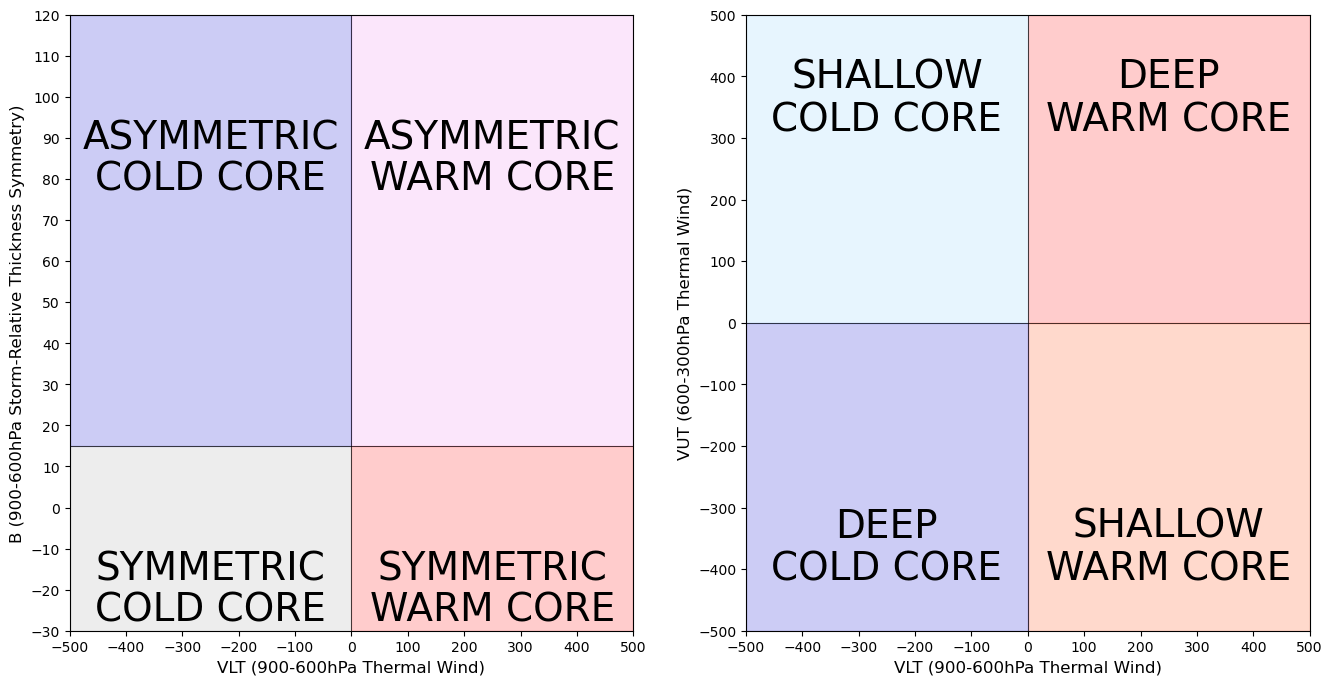

In [ ]:
Cyclone_Phase_Base(False)

In [18]:
# Plot Some Cyclone Tracks, SLP and Phase Plots

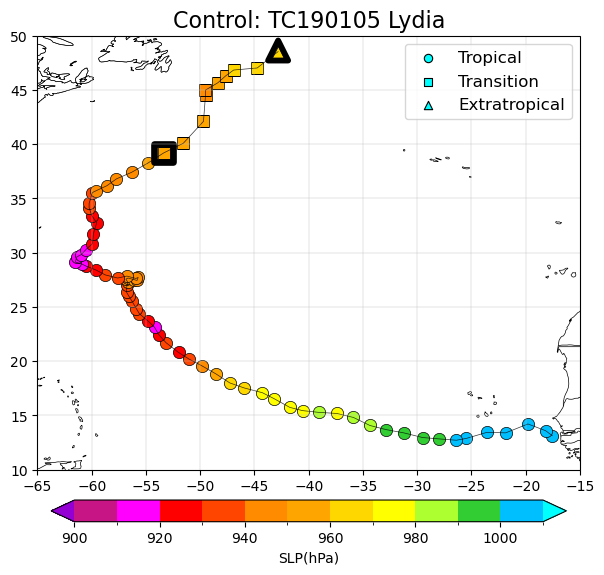

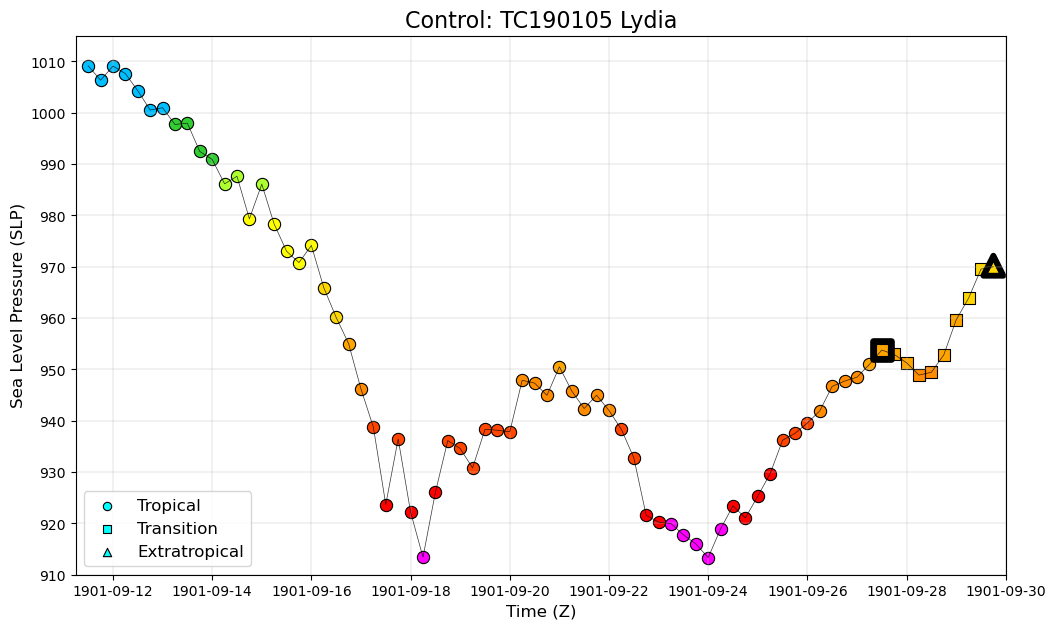

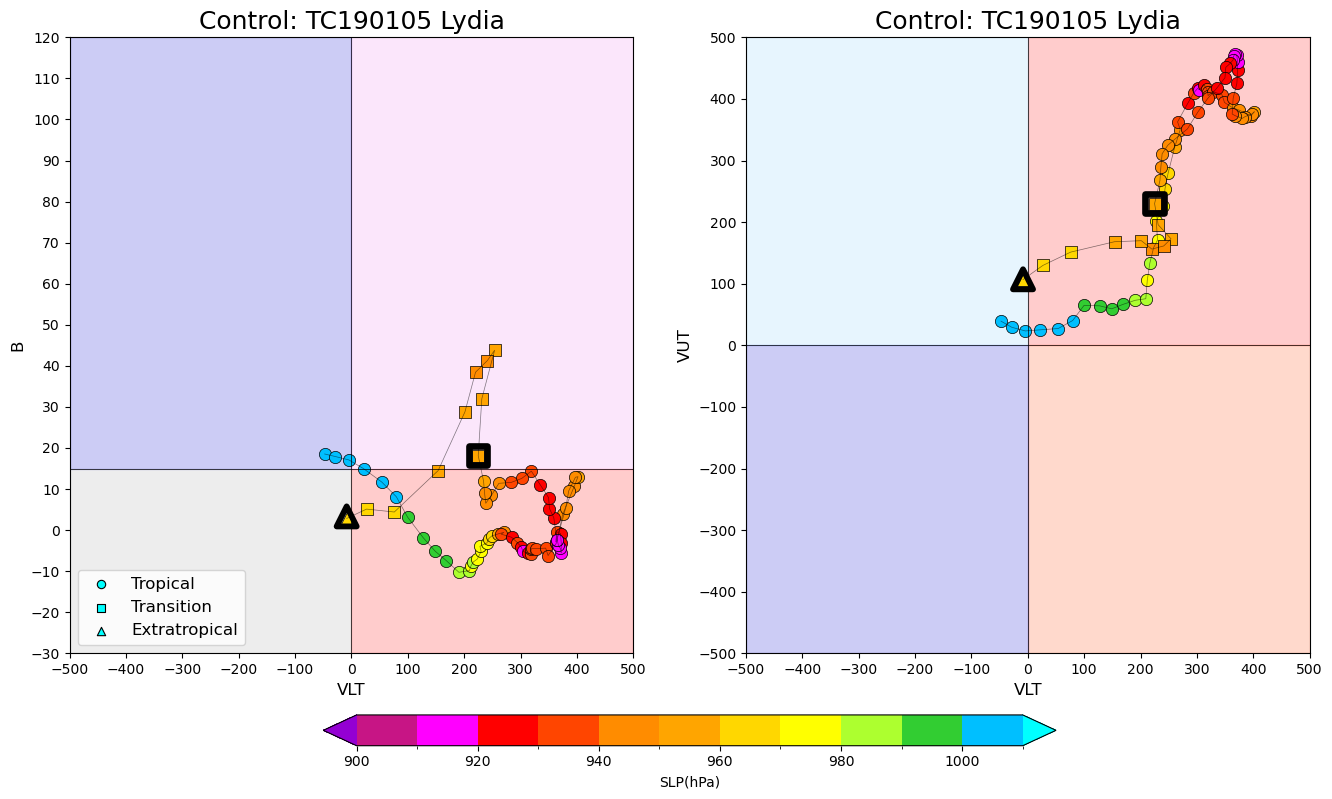

In [19]:
# Input Code
Code = 'TC190105'
Plot_Cyclone_Track(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 1, True, "Control", True, (7,7))
Plot_Cyclone_SLP(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", True)
Plot_Cyclone_Phase(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", True)

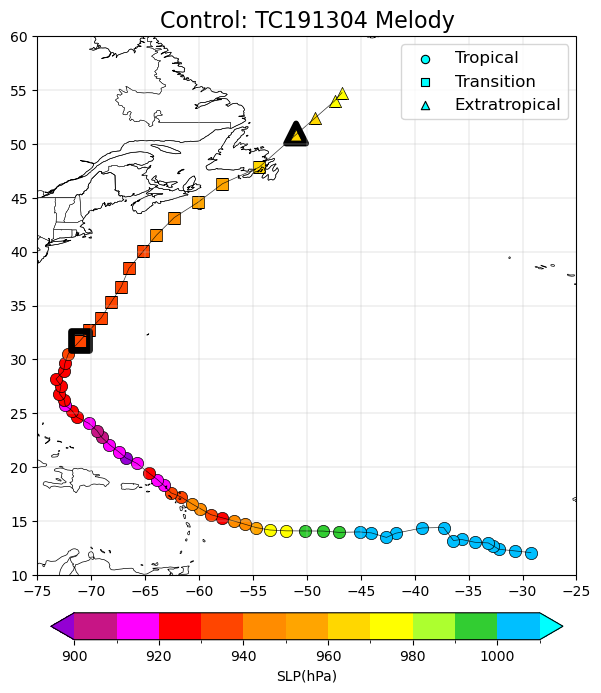

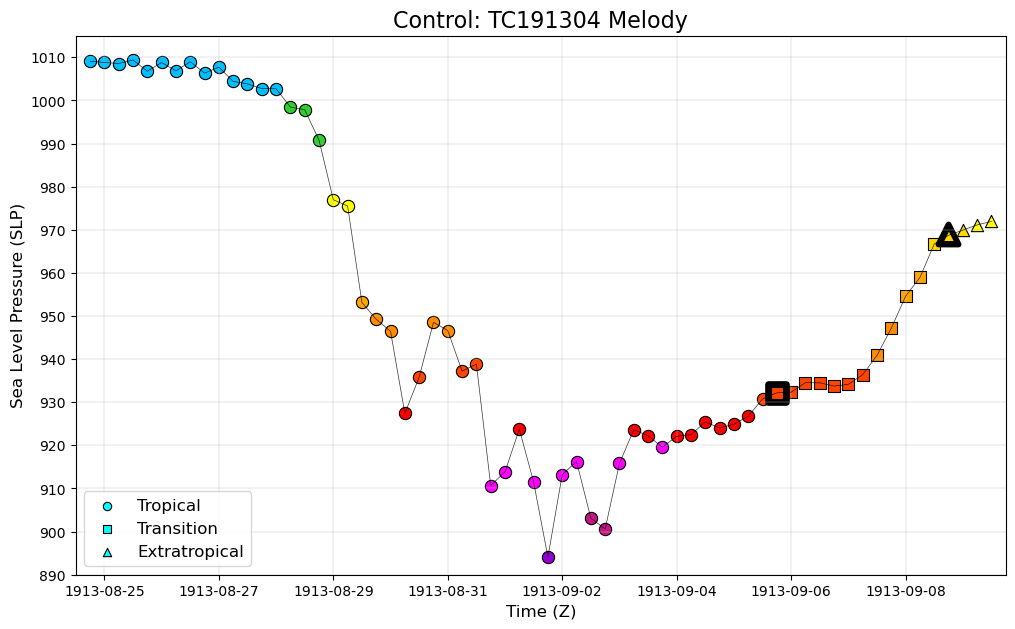

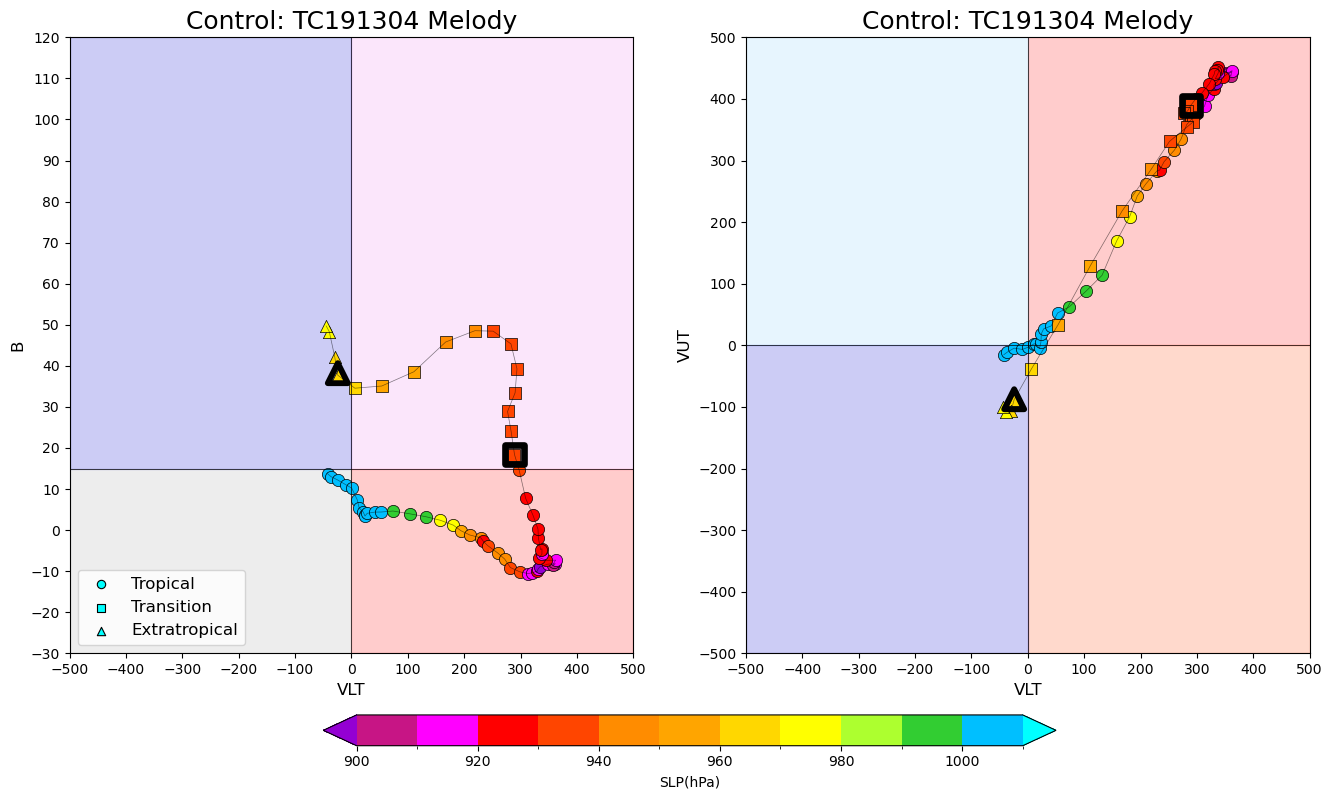

In [20]:
# Input Code
Code = 'TC191304'
Plot_Cyclone_Track(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 1, True, "Control", True, (7,7))
Plot_Cyclone_SLP(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", True)
Plot_Cyclone_Phase(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", True)

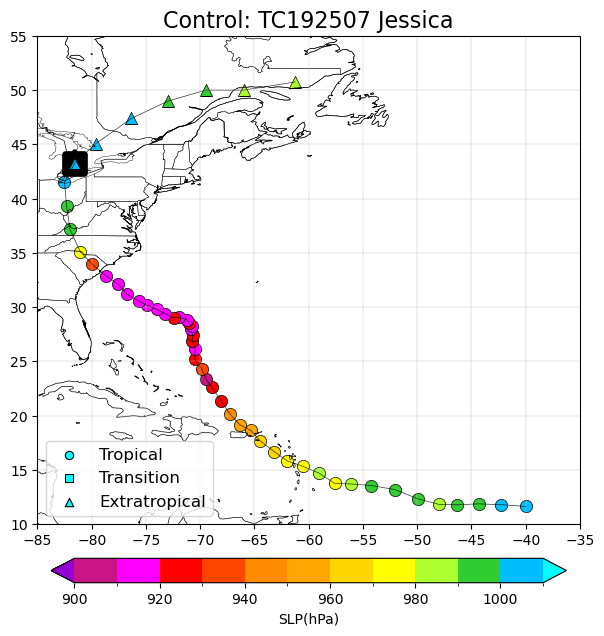

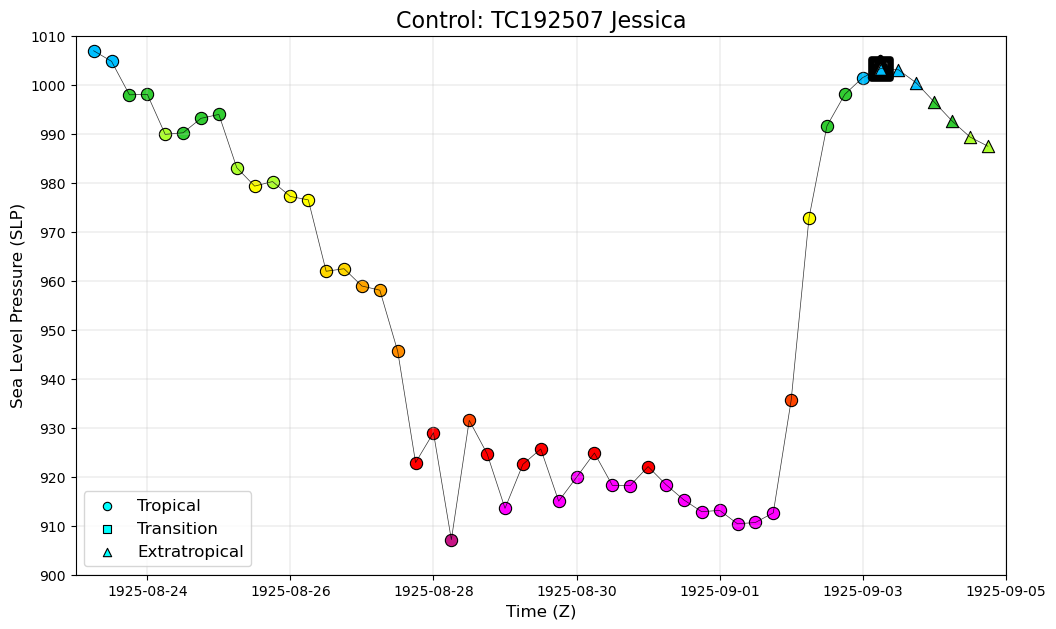

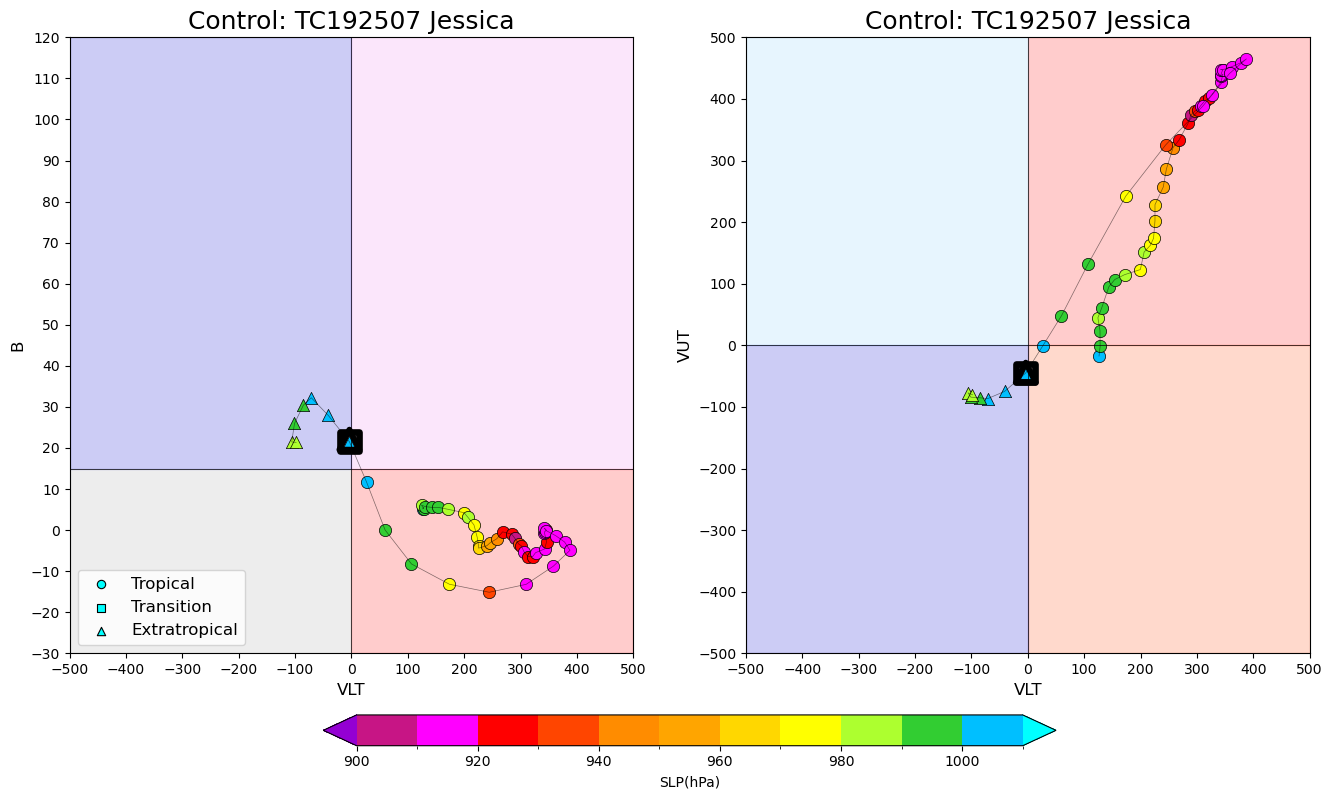

In [21]:
# Input Code
Code = 'TC192507'
Plot_Cyclone_Track(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", True, (7,7))
Plot_Cyclone_SLP(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", True)
Plot_Cyclone_Phase(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", True)

In [ ]:
# Input Code
Code = 'TC194706'
Plot_Cyclone_Track(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 1, True, "Control", False, (8,6))
Plot_Cyclone_SLP(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", False)
Plot_Cyclone_Phase(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", False)

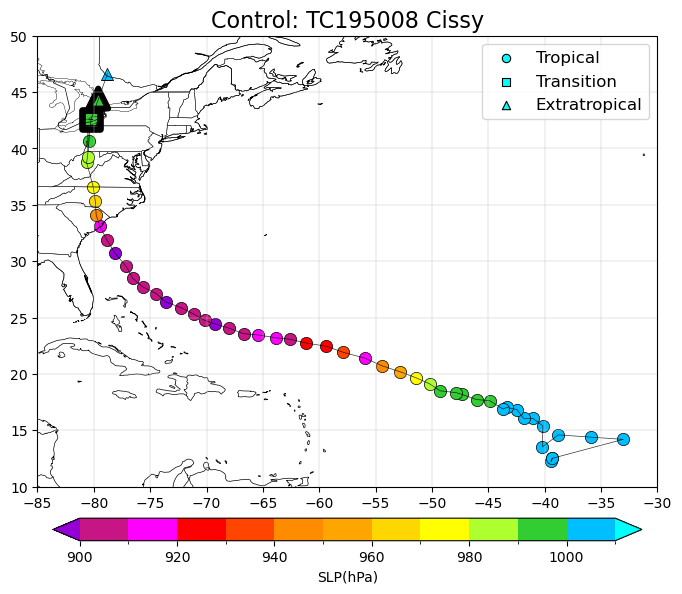

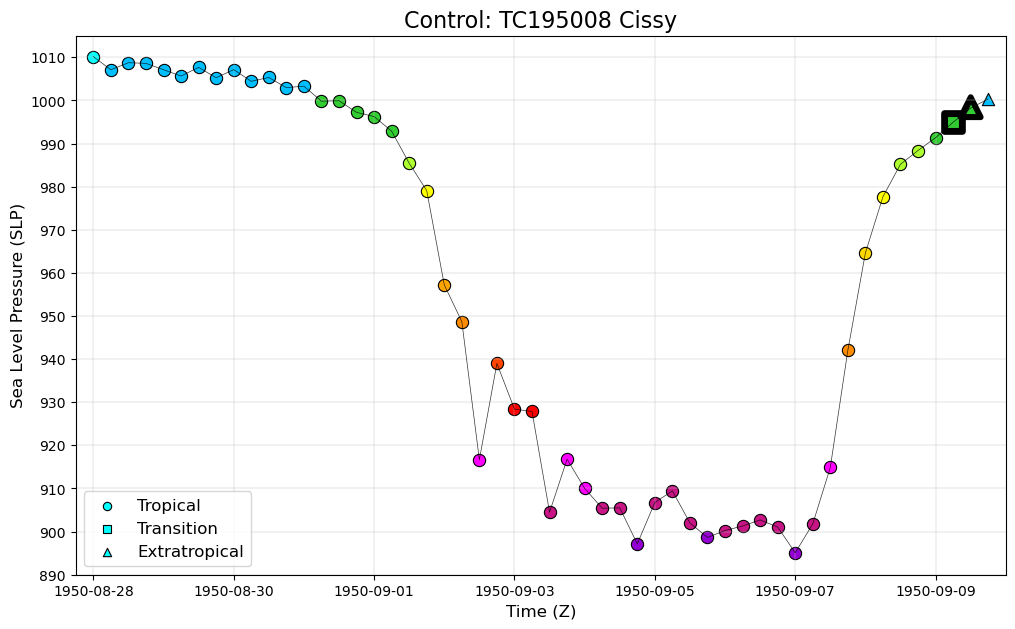

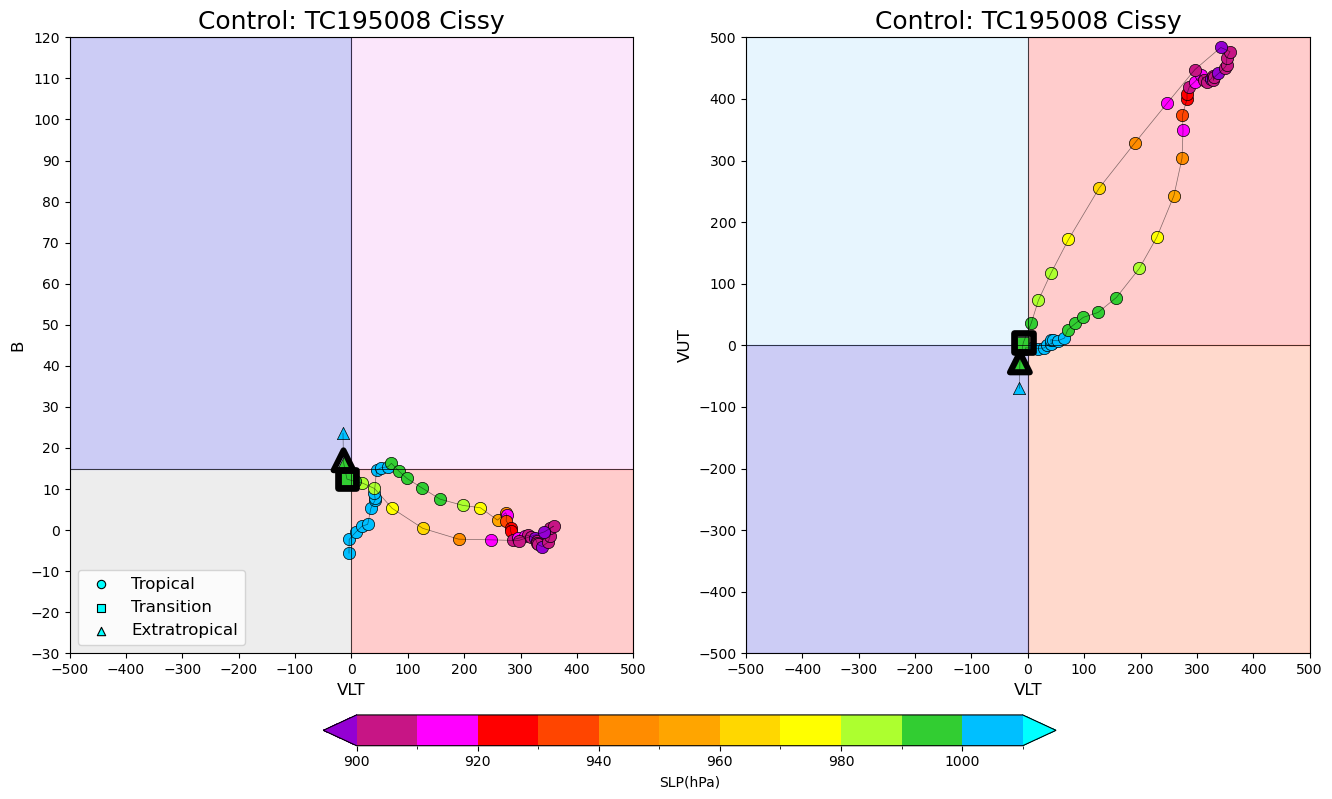

In [22]:
# Input Code
Code = 'TC195008'
Plot_Cyclone_Track(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 1, True, "Control", True, (8,6))
Plot_Cyclone_SLP(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", True)
Plot_Cyclone_Phase(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", True)

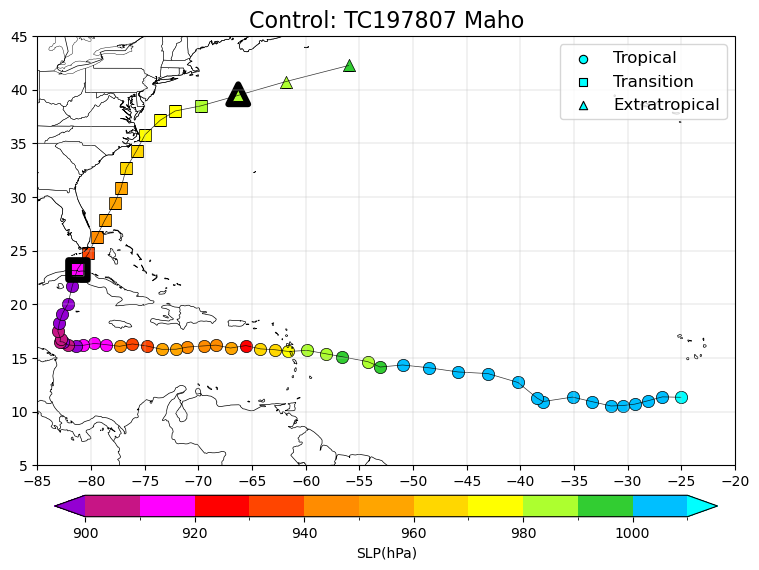

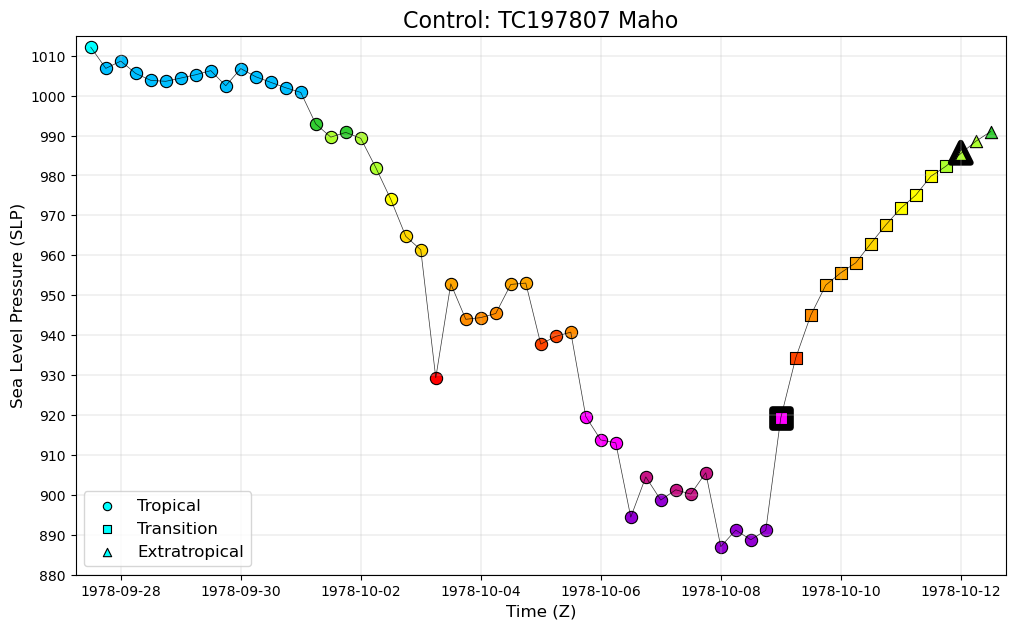

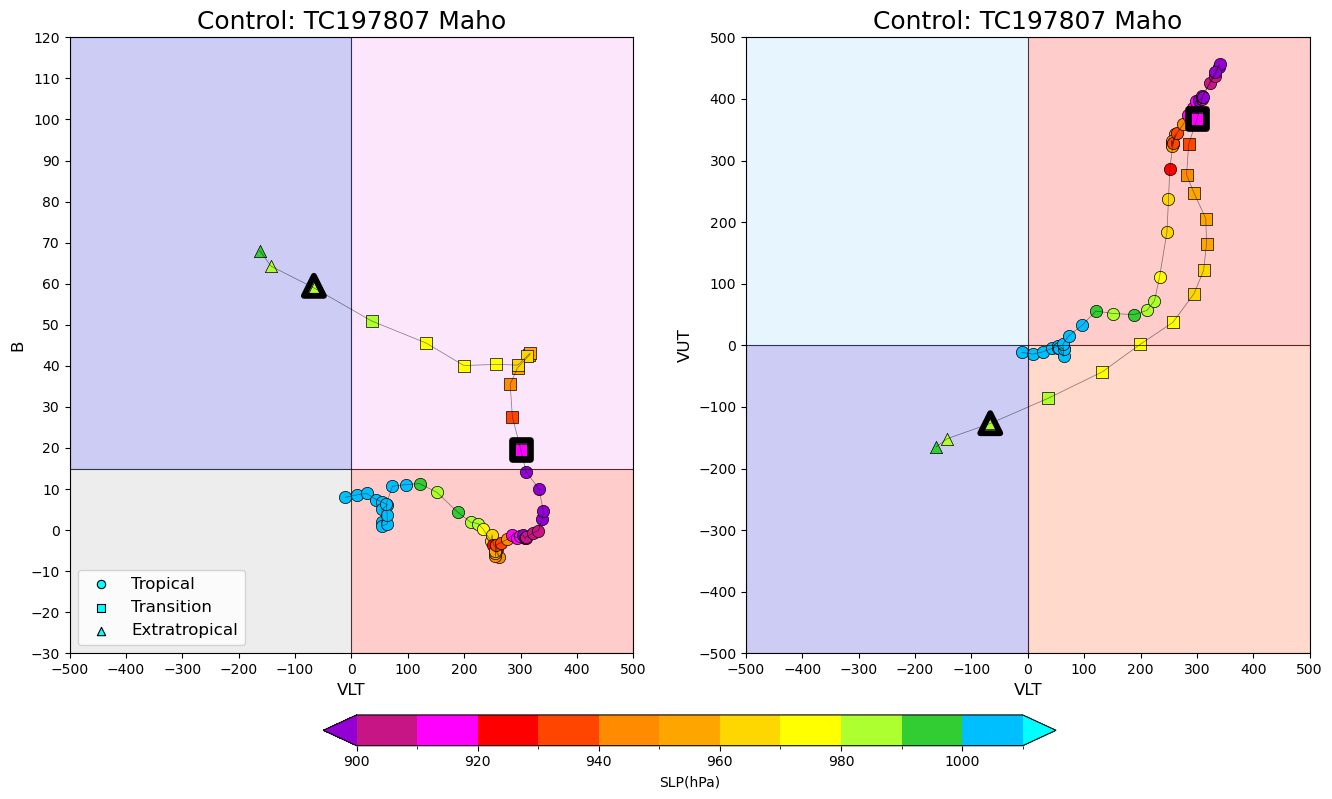

In [23]:
# Input Code
Code = 'TC197807'
Plot_Cyclone_Track(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 1, True, "Control", True, (9,6))
Plot_Cyclone_SLP(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", True)
Plot_Cyclone_Phase(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", True)

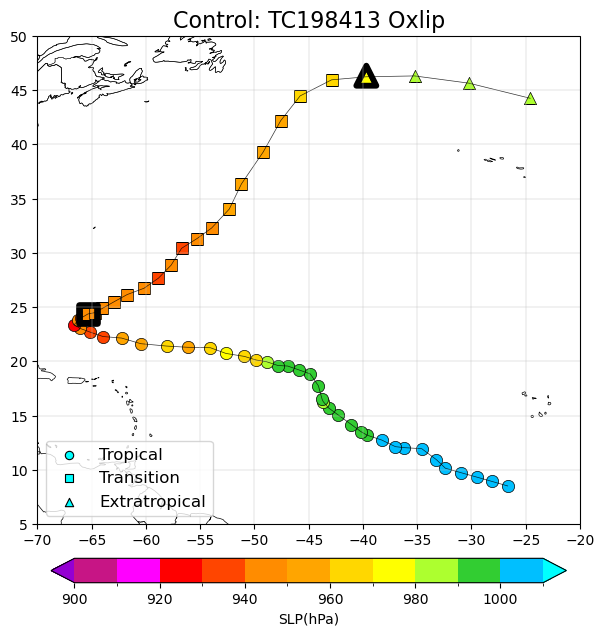

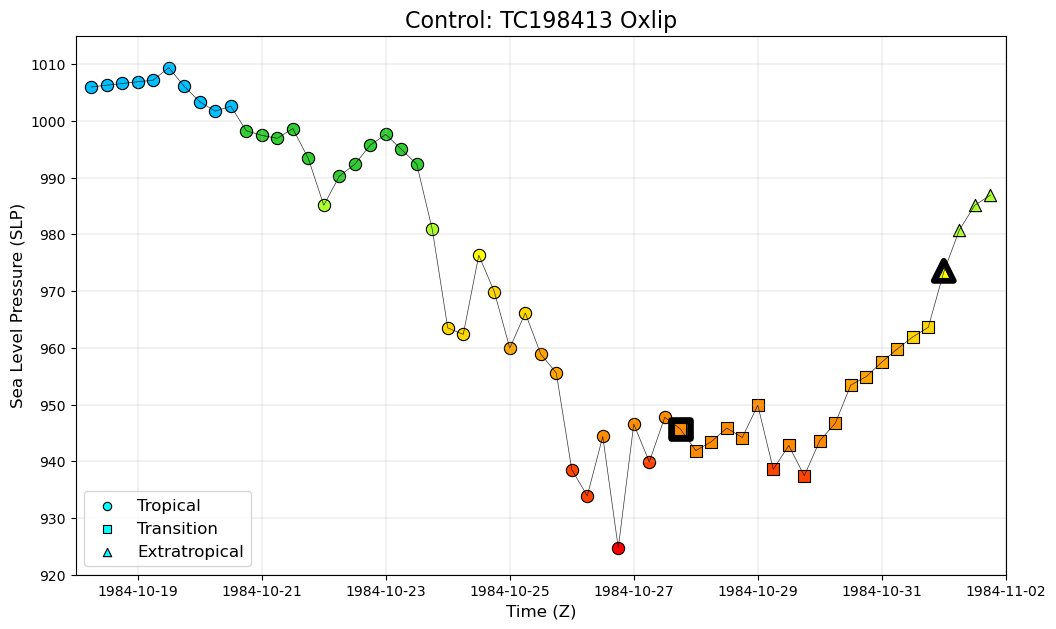

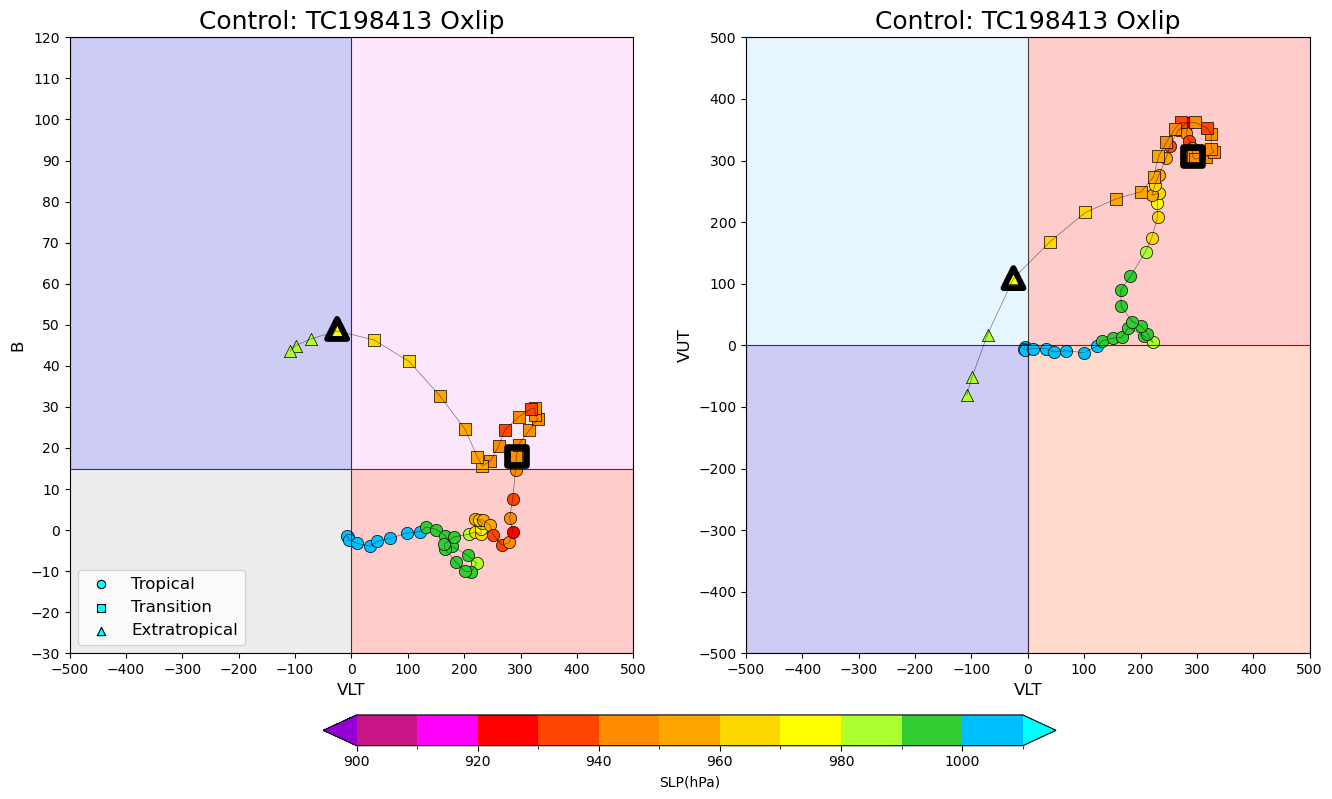

In [24]:
# Input Code
Code = 'TC198413'
Plot_Cyclone_Track(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", True, (7,7))
Plot_Cyclone_SLP(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", True)
Plot_Cyclone_Phase(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", True)

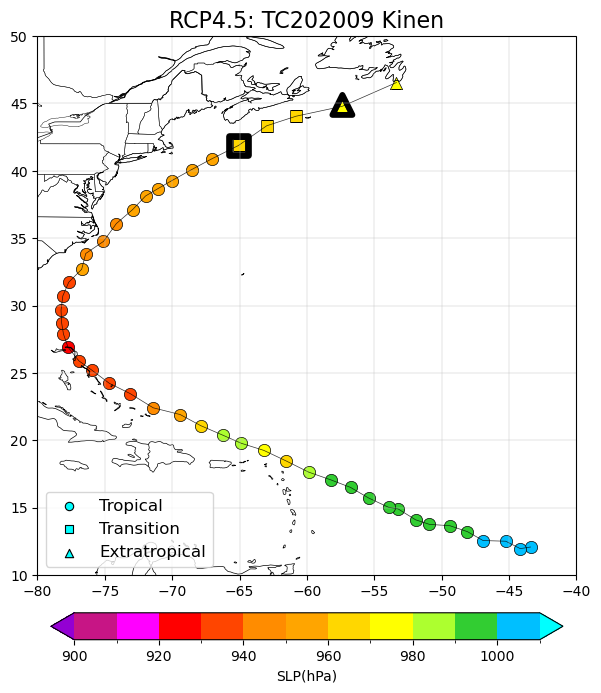

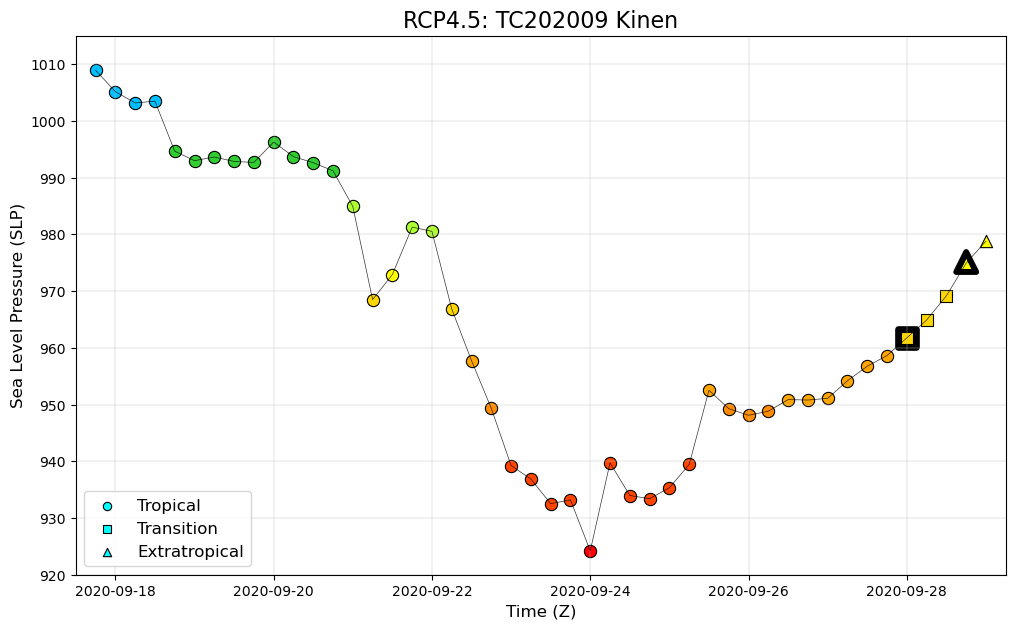

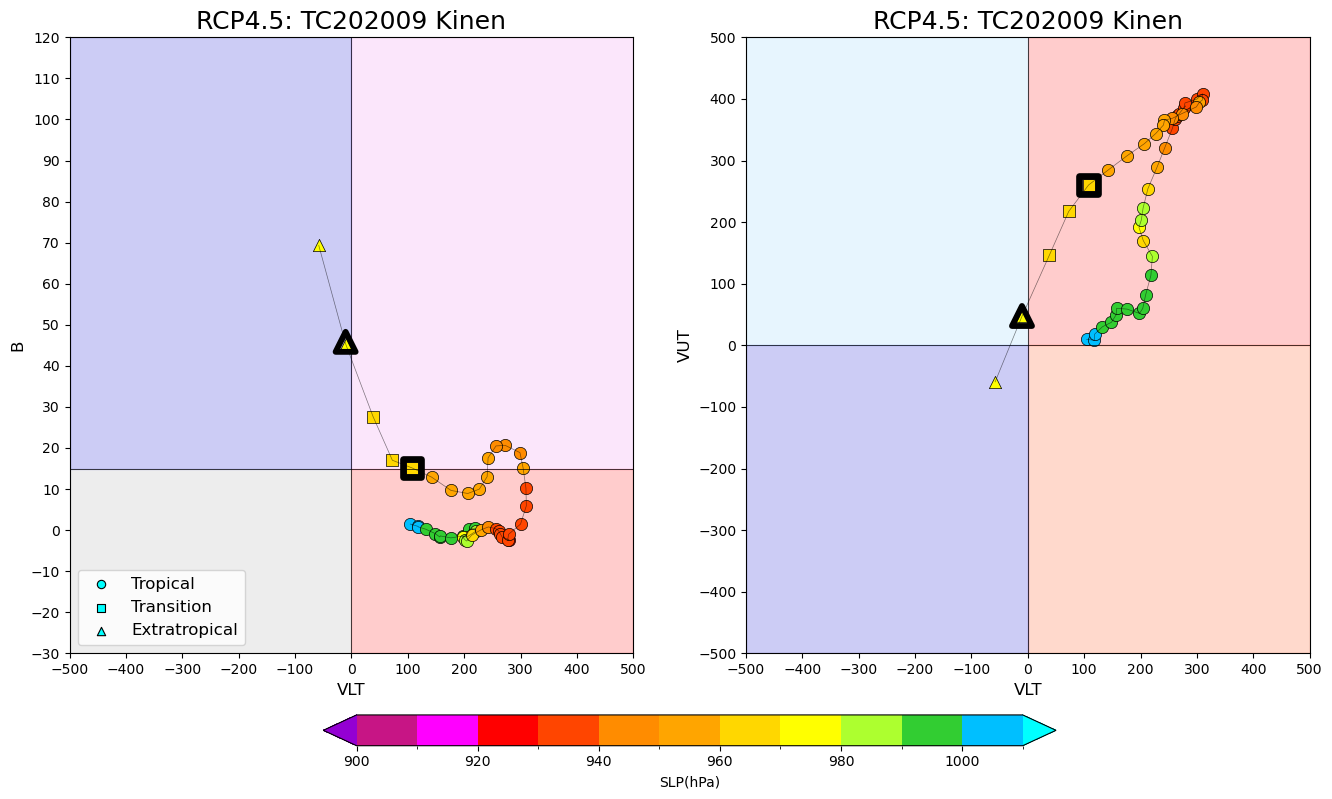

In [25]:
# Input Code
Code = 'TC202009'
Plot_Cyclone_Track(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP4.5", True, (7,7))
Plot_Cyclone_SLP(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP4.5", True)
Plot_Cyclone_Phase(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP4.5", True)

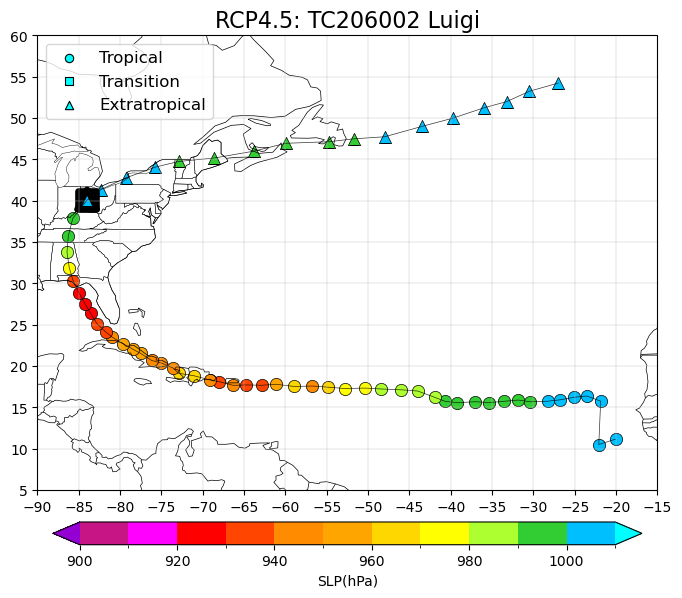

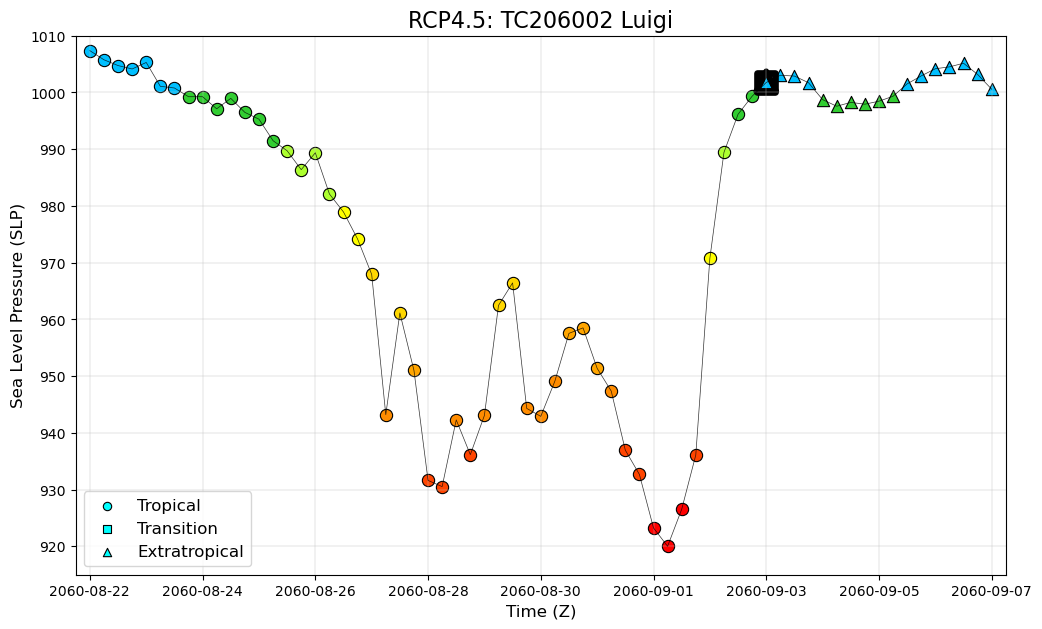

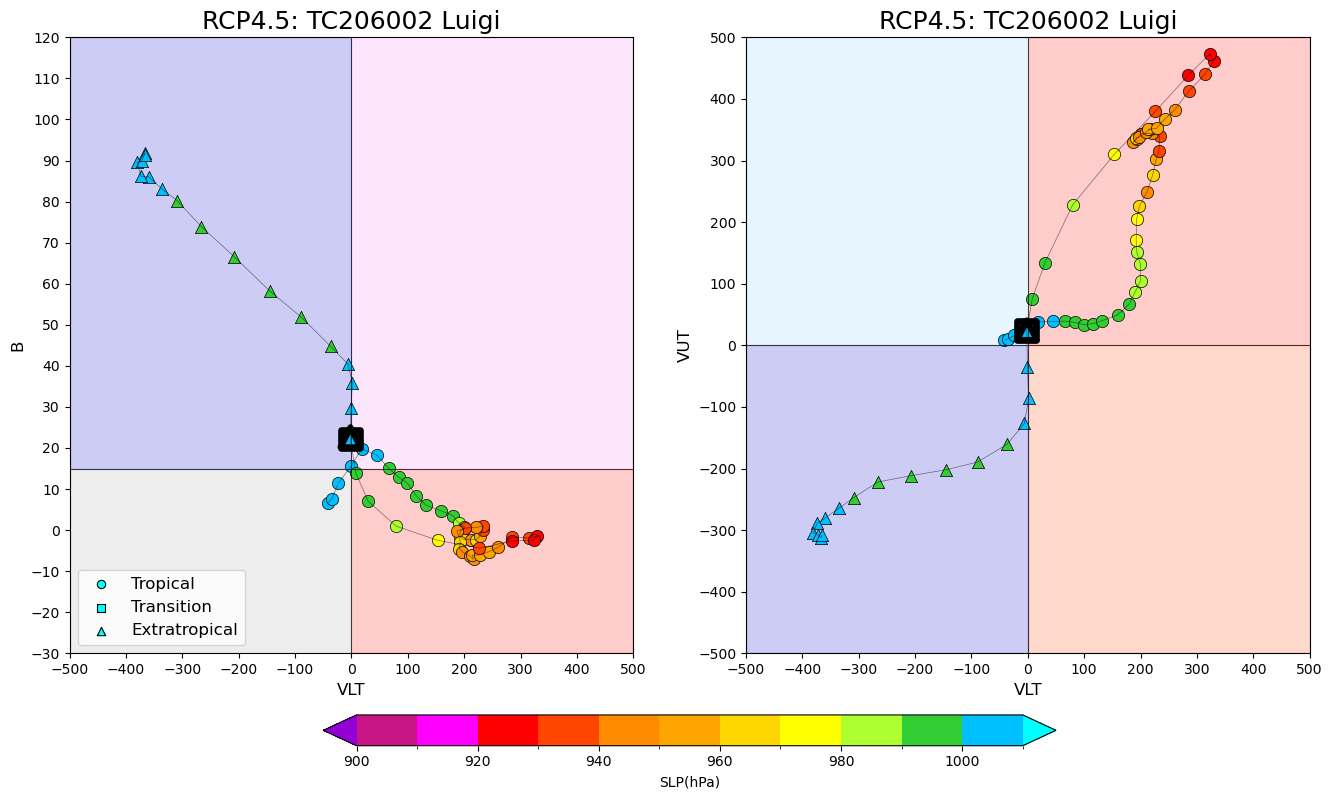

In [26]:
# Input Code
Code = 'TC206002'
Plot_Cyclone_Track(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 2, True, "RCP4.5", True, (8,6))
Plot_Cyclone_SLP(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP4.5", True)
Plot_Cyclone_Phase(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP4.5", True)

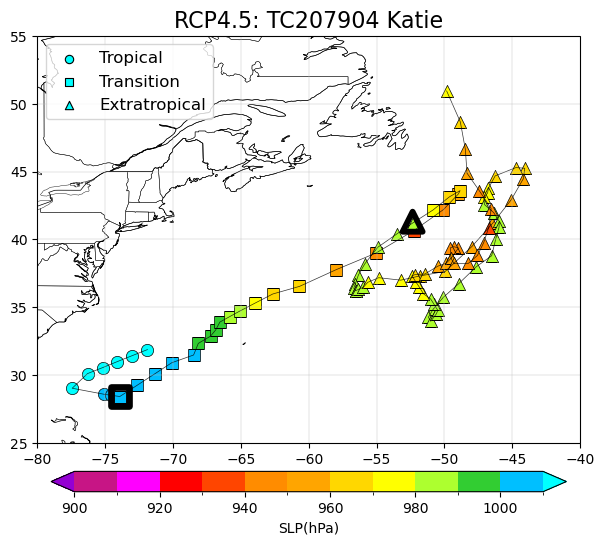

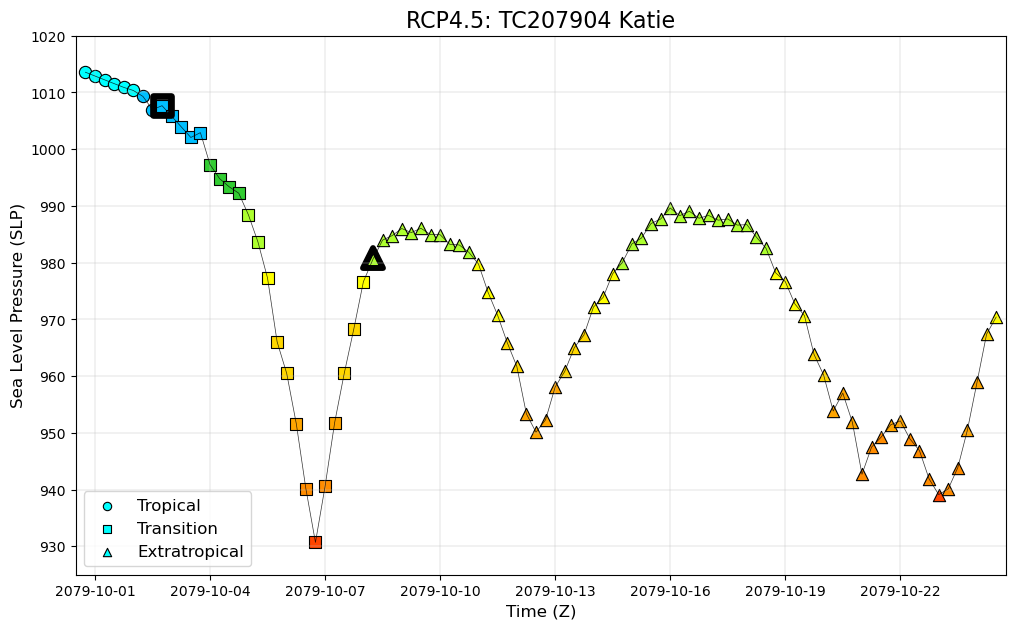

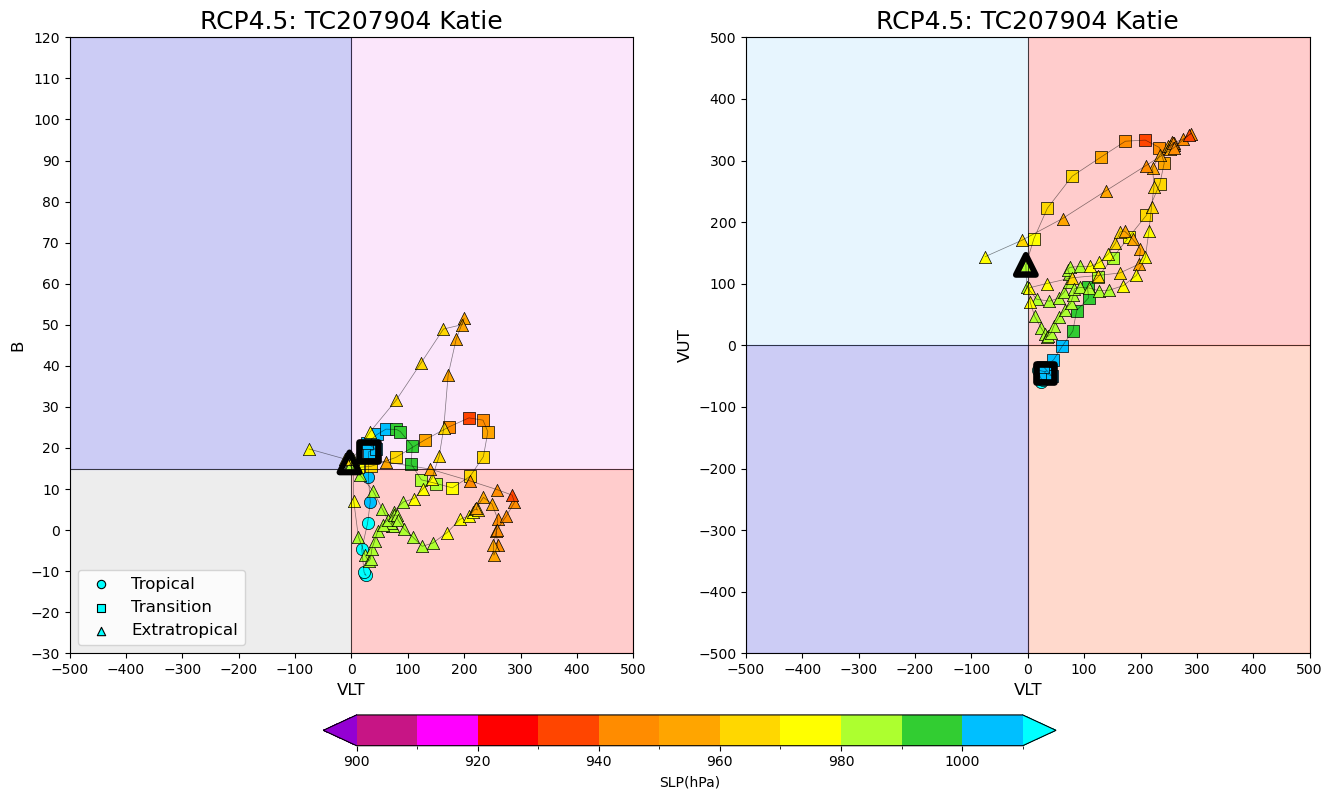

In [27]:
# Input Code
Code = 'TC207904'
Plot_Cyclone_Track(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 2, True, "RCP4.5", True, (7,6))
Plot_Cyclone_SLP(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP4.5", True)
Plot_Cyclone_Phase(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP4.5", True)

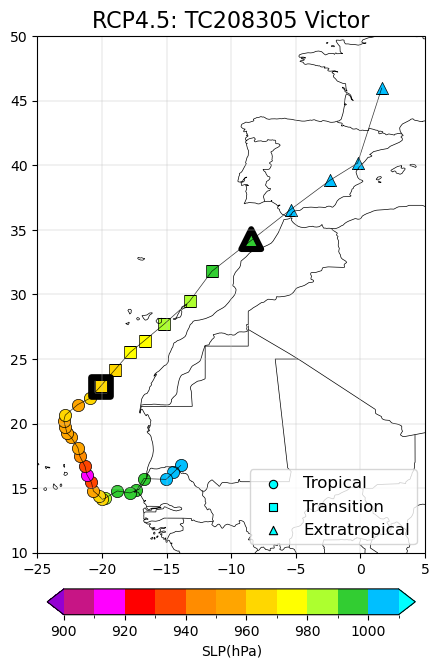

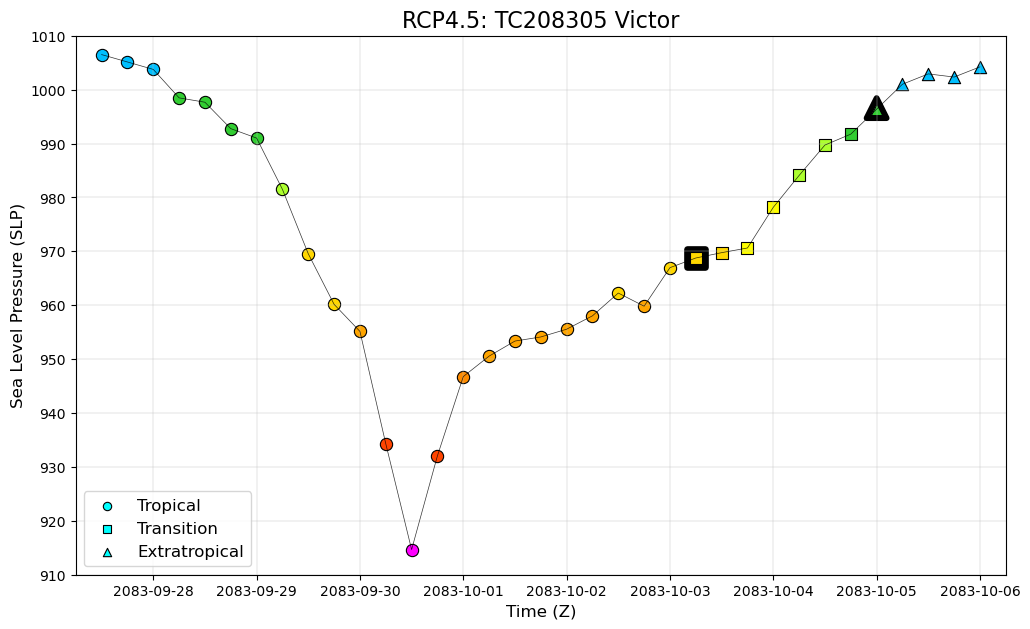

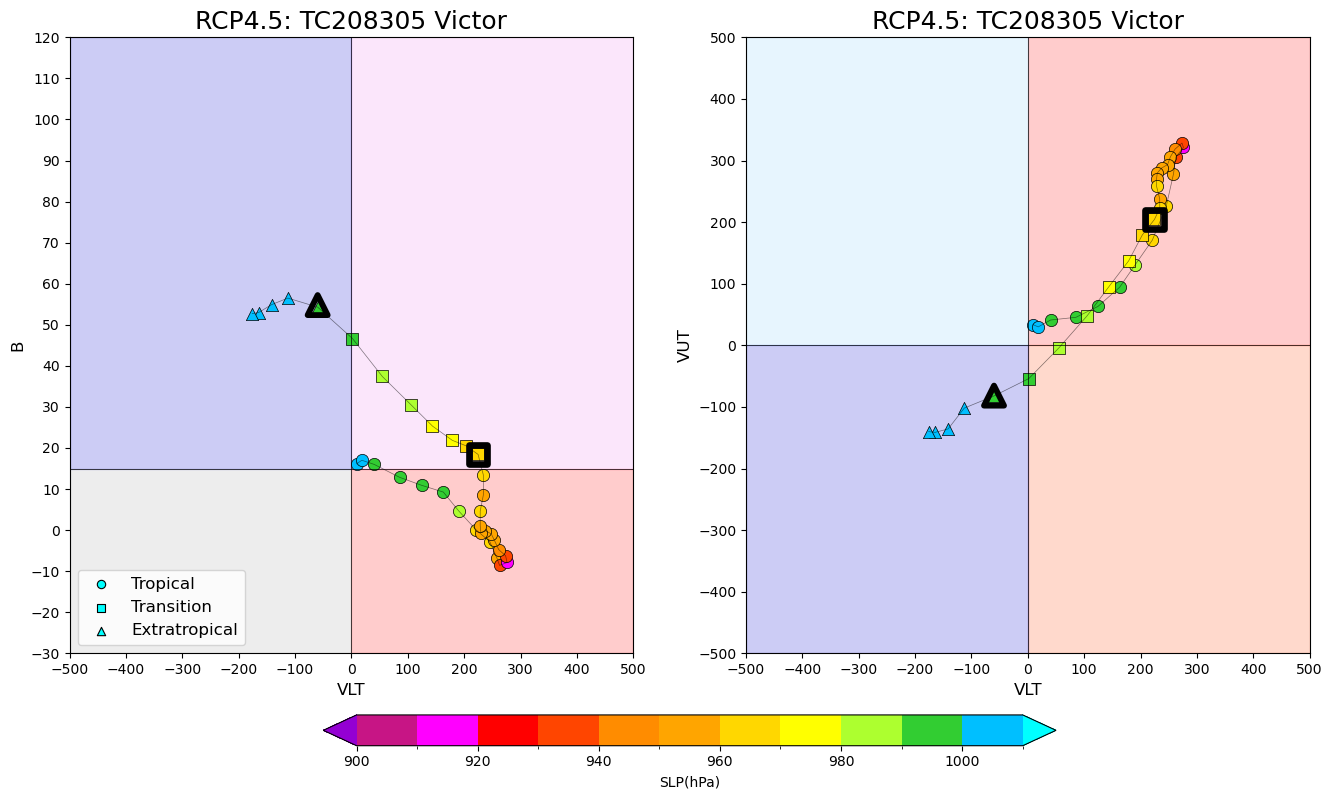

In [28]:
# Input Code
Code = 'TC208305'
Plot_Cyclone_Track(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 4, True, "RCP4.5", True, (5,9))
Plot_Cyclone_SLP(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP4.5", True)
Plot_Cyclone_Phase(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP4.5", True)

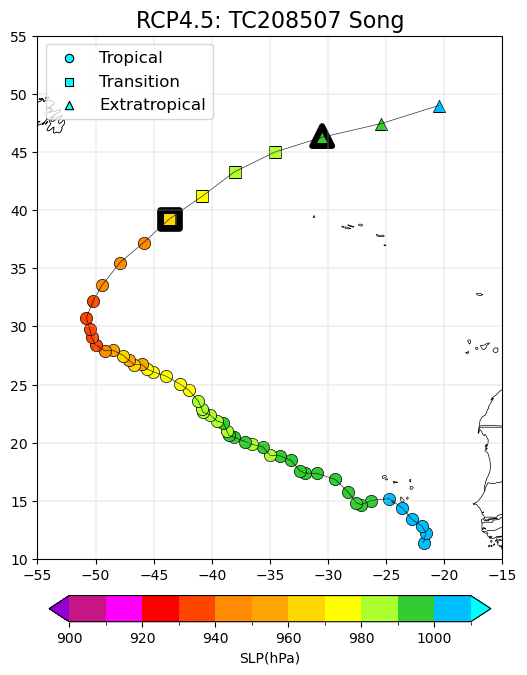

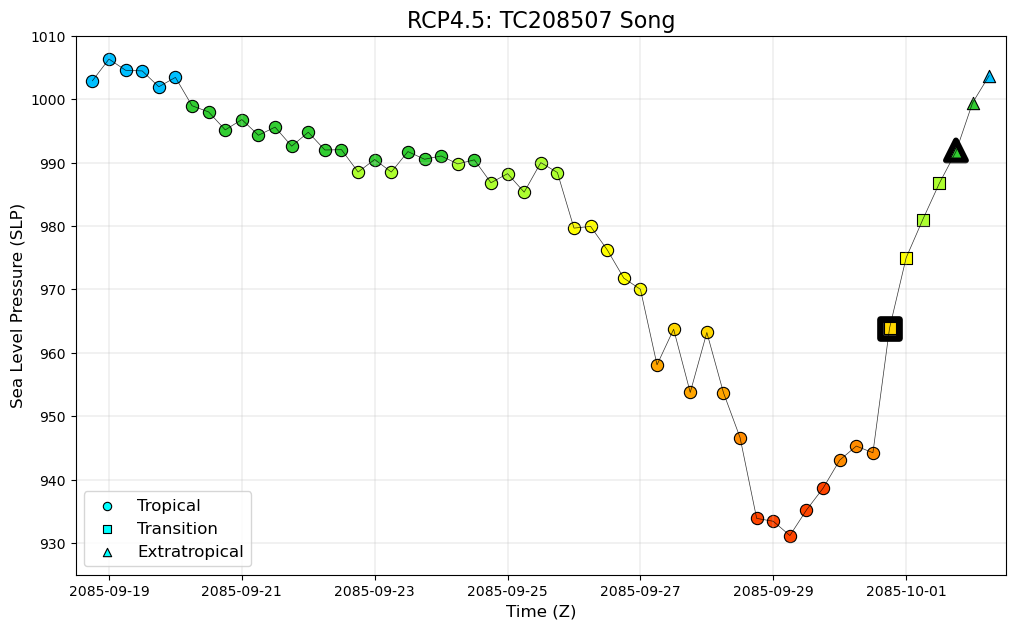

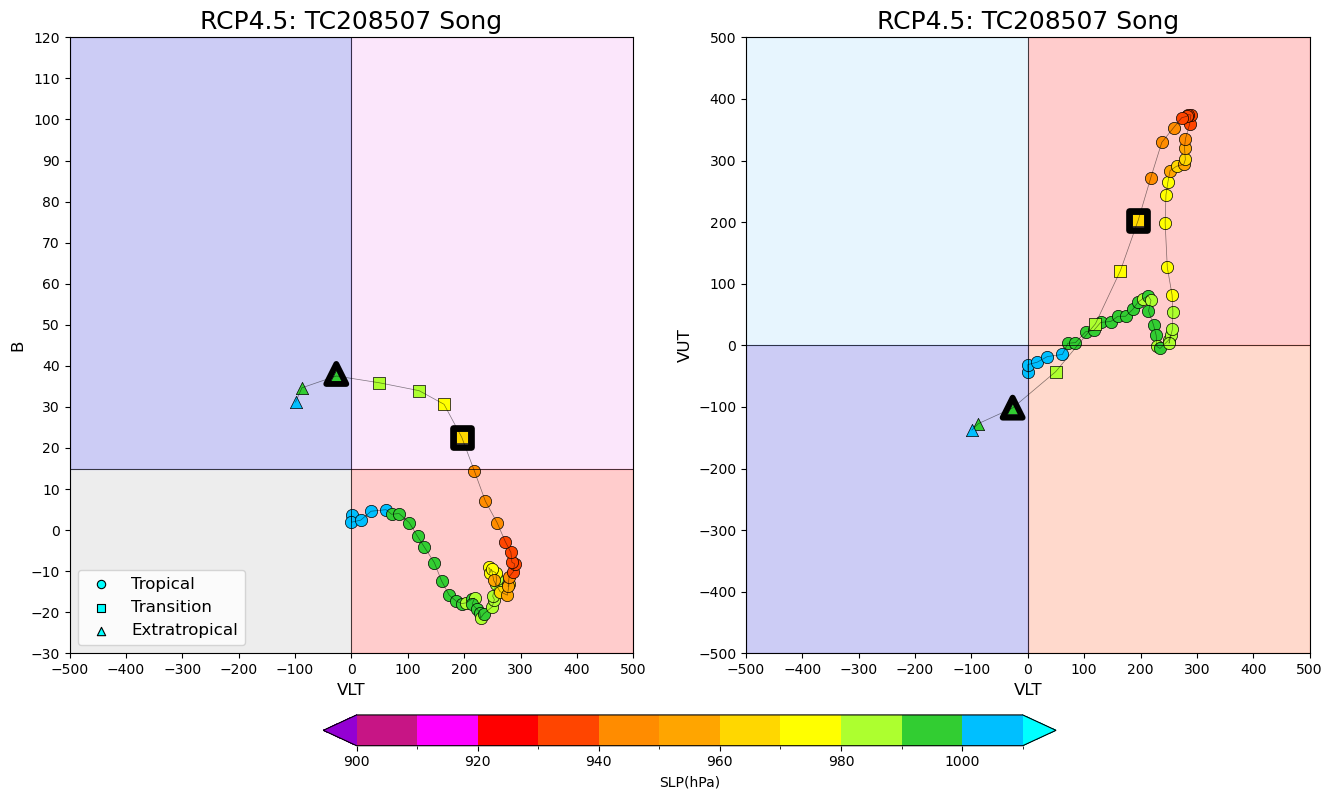

In [29]:
# Input Code
Code = 'TC208507'
Plot_Cyclone_Track(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 2, True, "RCP4.5", True, (6,7))
Plot_Cyclone_SLP(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP4.5", True)
Plot_Cyclone_Phase(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP4.5", True)

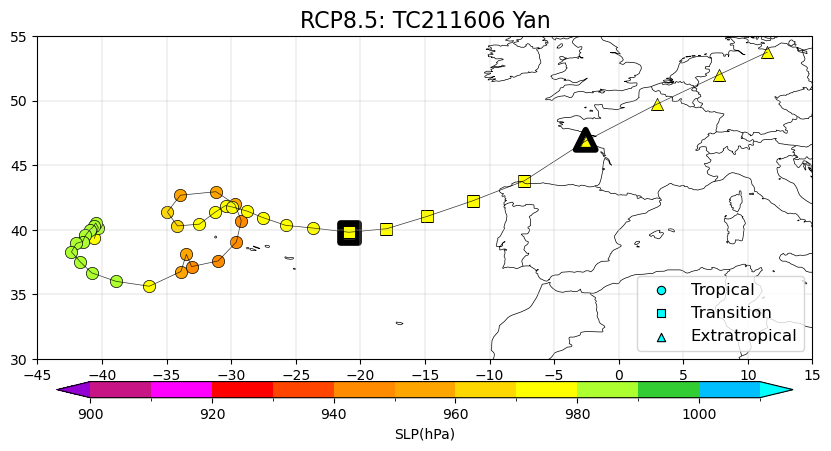

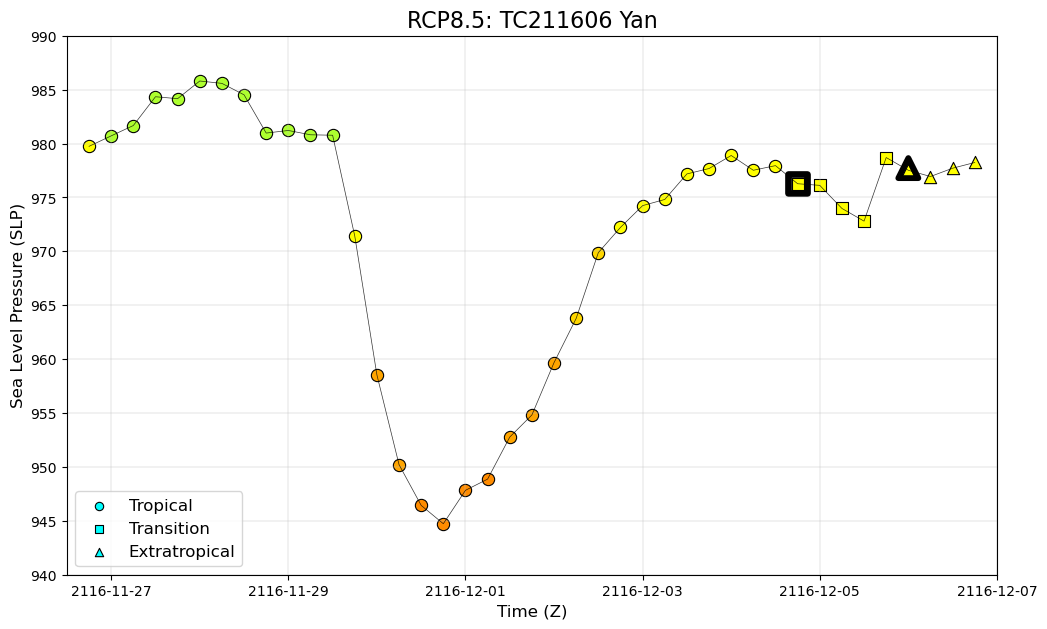

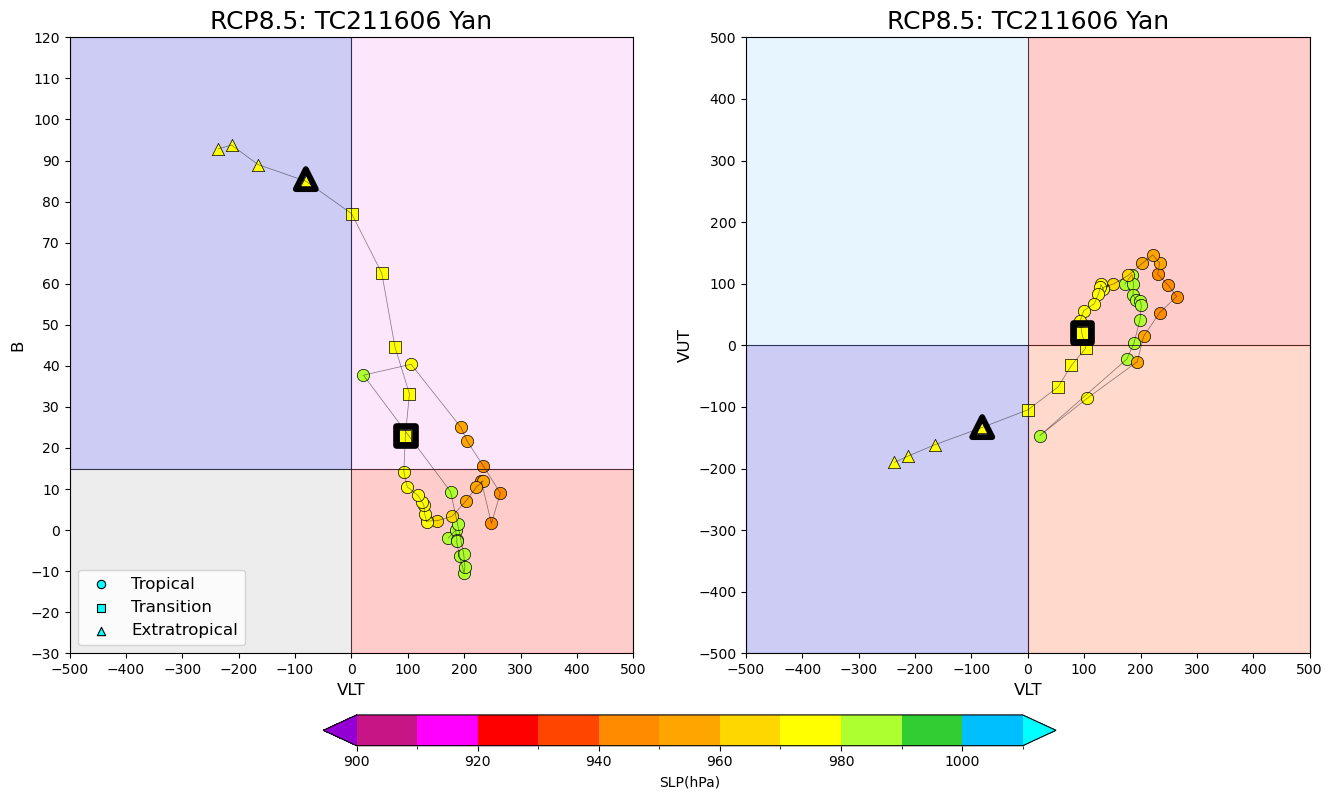

In [30]:
# Input Code
Code = 'TC211606'
Plot_Cyclone_Track(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 4, True, "RCP8.5", True, (10,5))
Plot_Cyclone_SLP(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP8.5", True)
Plot_Cyclone_Phase(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP8.5", True)

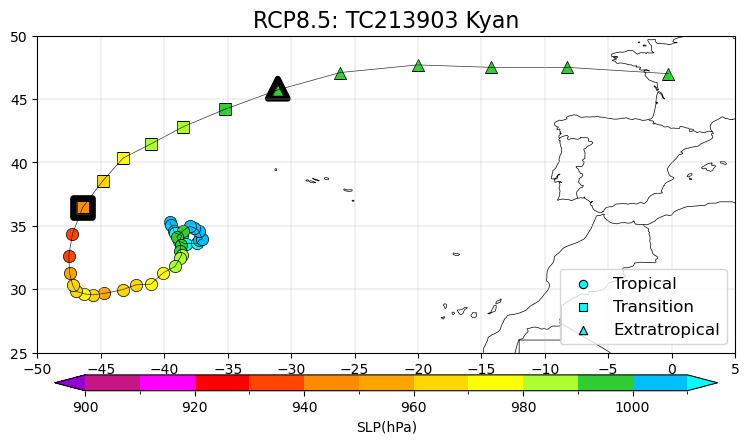

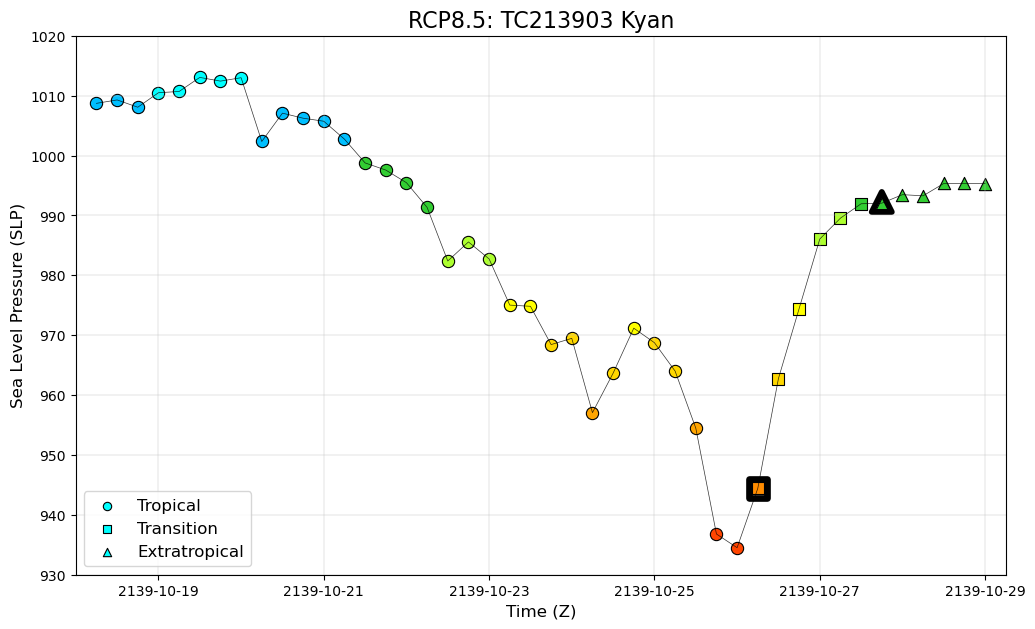

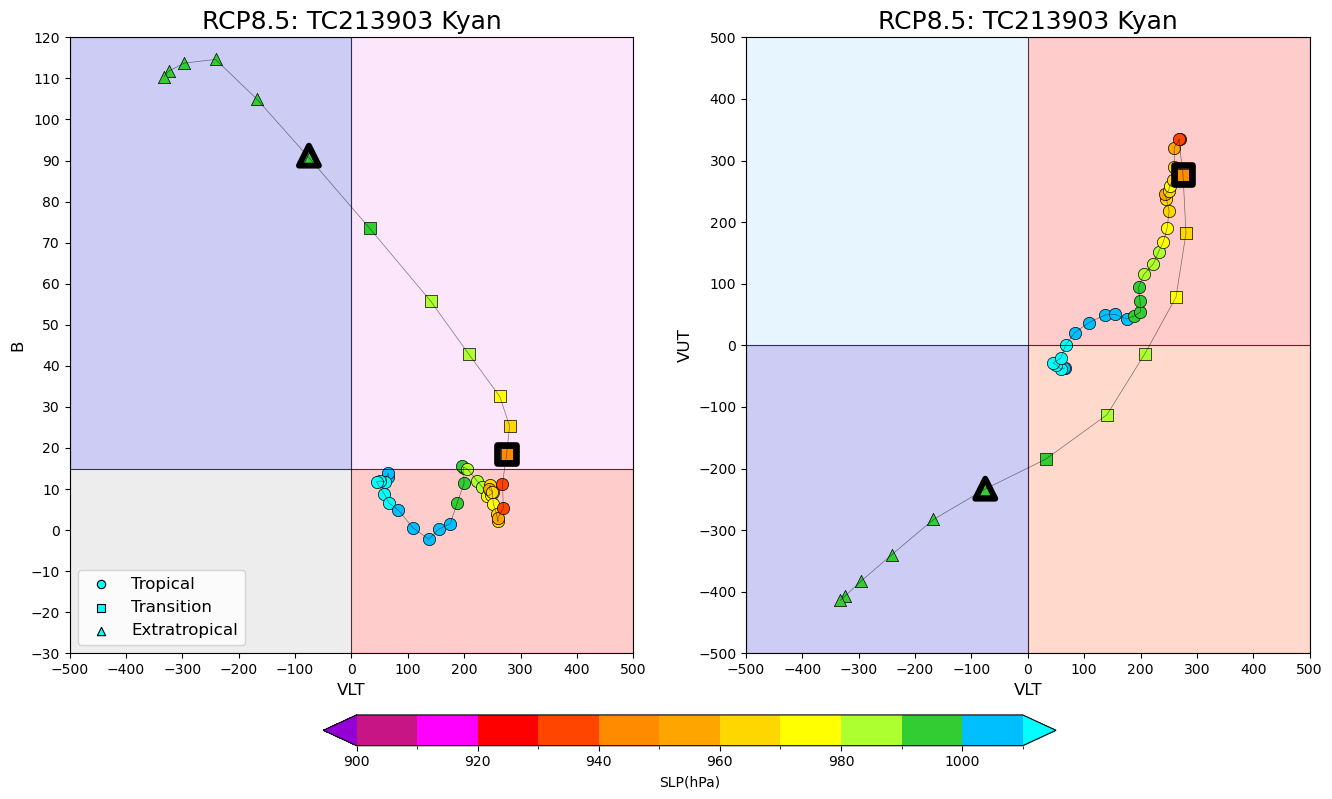

In [31]:
# Input Code
Code = 'TC213903'
Plot_Cyclone_Track(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 4, True, "RCP8.5", True, (9,5))
Plot_Cyclone_SLP(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP8.5", True)
Plot_Cyclone_Phase(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP8.5", True)

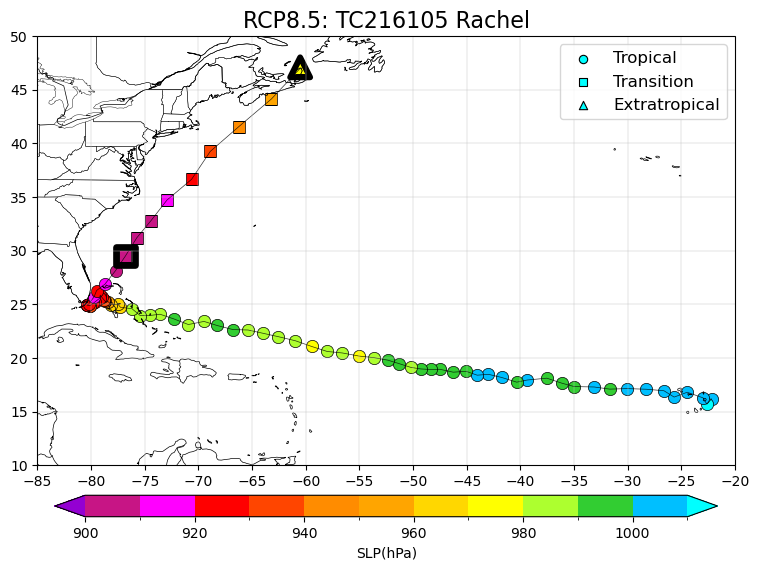

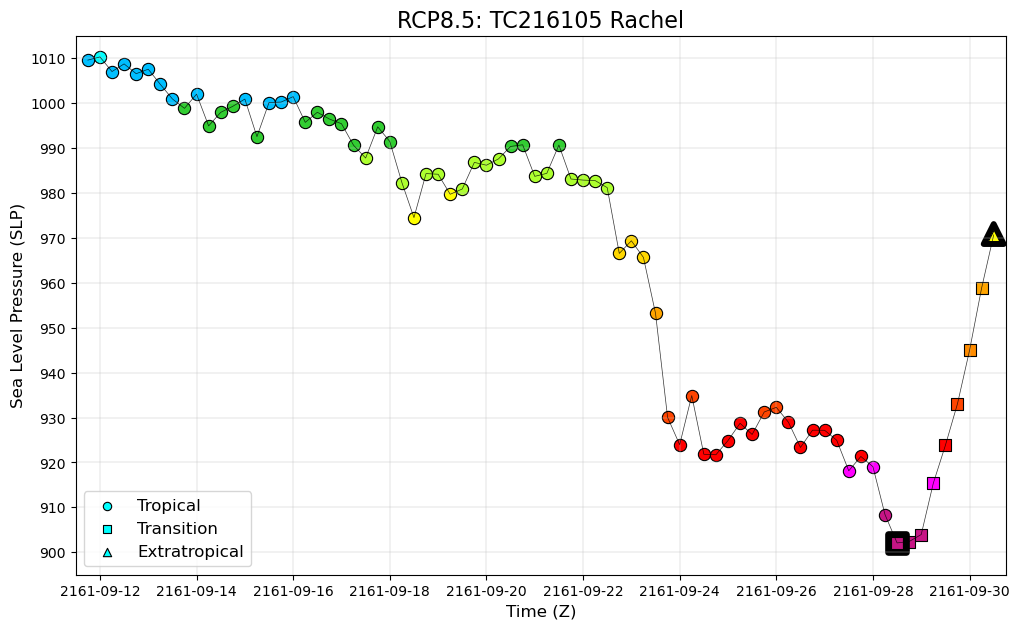

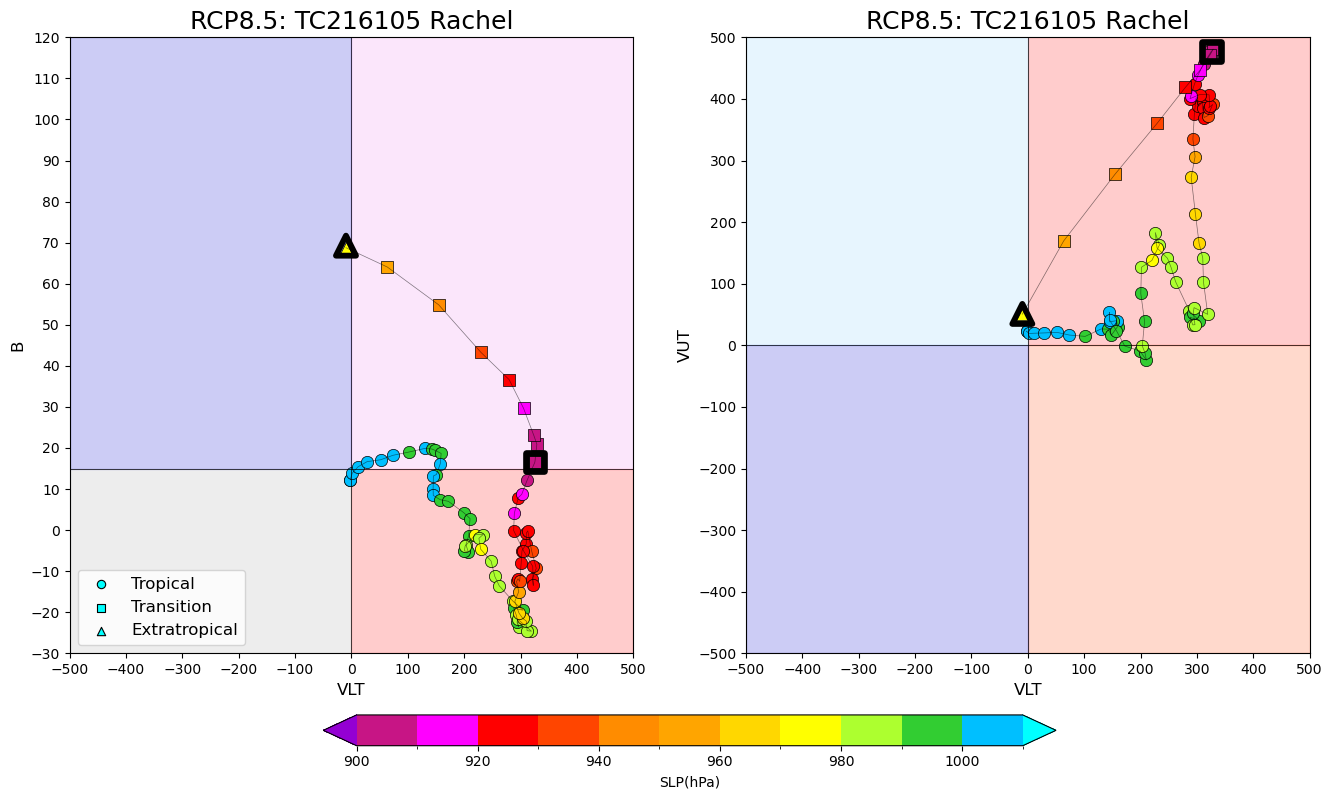

In [32]:
# Input Code
Code = 'TC216105'
Plot_Cyclone_Track(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 1, True, "RCP8.5", True, (9,6))
Plot_Cyclone_SLP(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP8.5", True)
Plot_Cyclone_Phase(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP8.5", True)

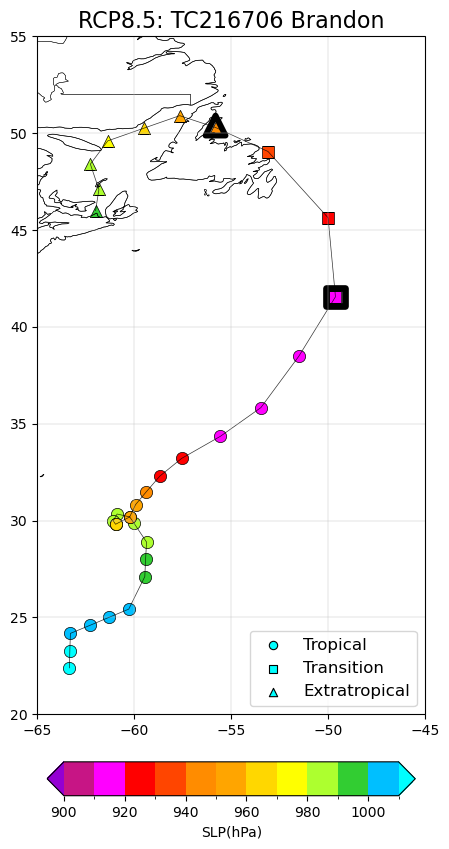

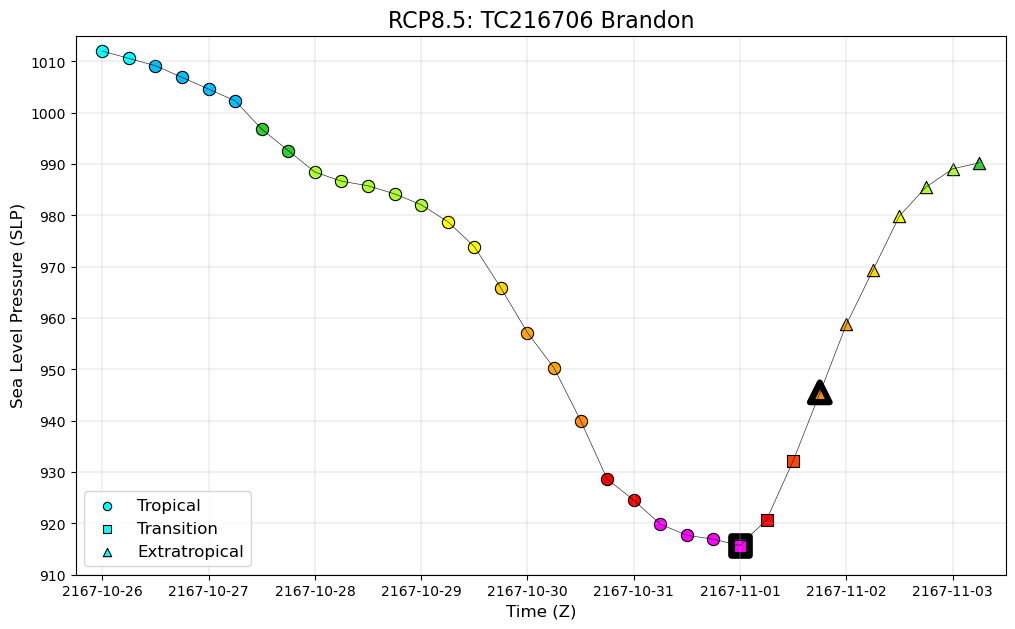

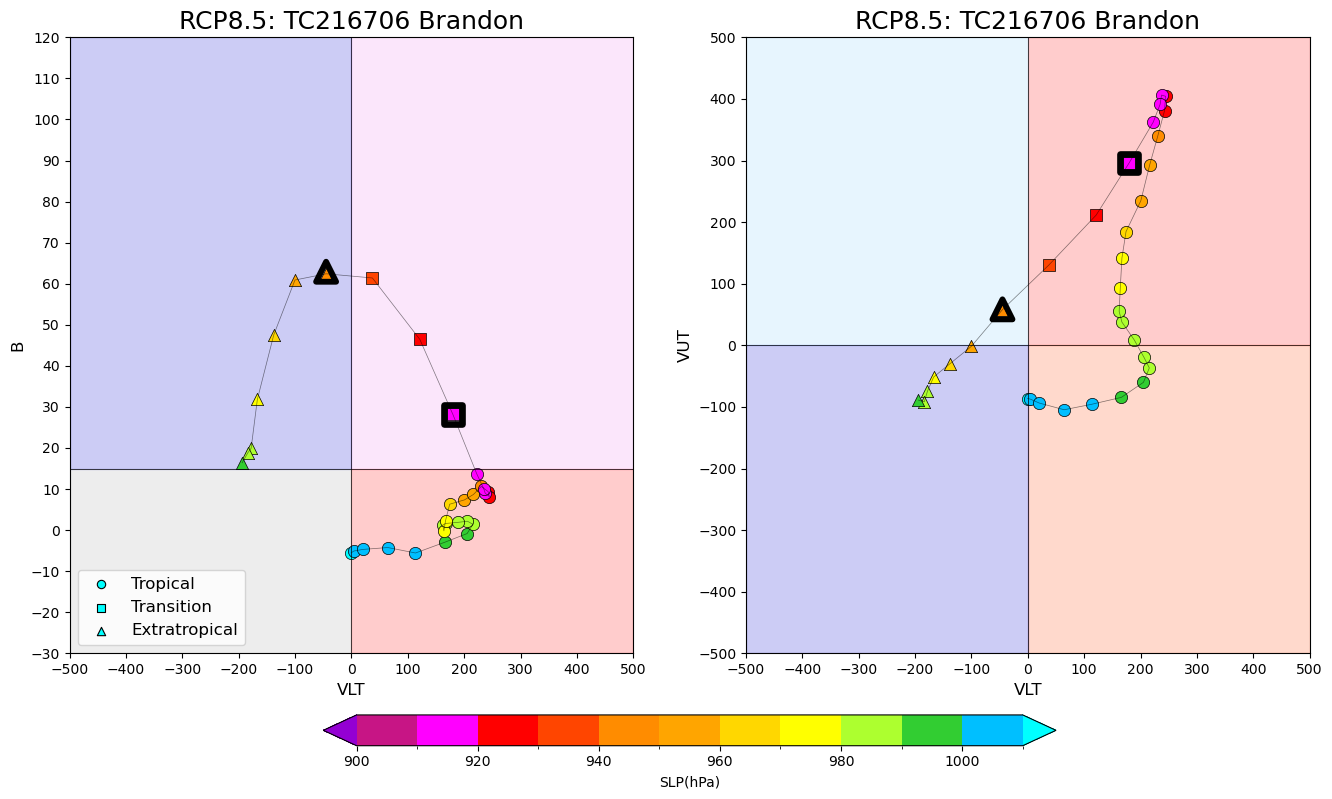

In [ ]:
# Input Code
Code = 'TC216706'
Plot_Cyclone_Track(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 4, True, "RCP8.5", True, (5,9))
Plot_Cyclone_SLP(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP8.5", True)
Plot_Cyclone_Phase(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP8.5", True)

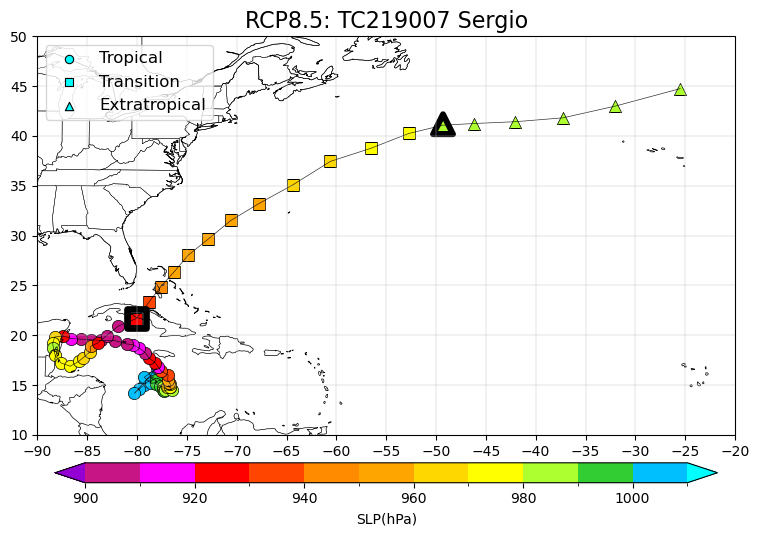

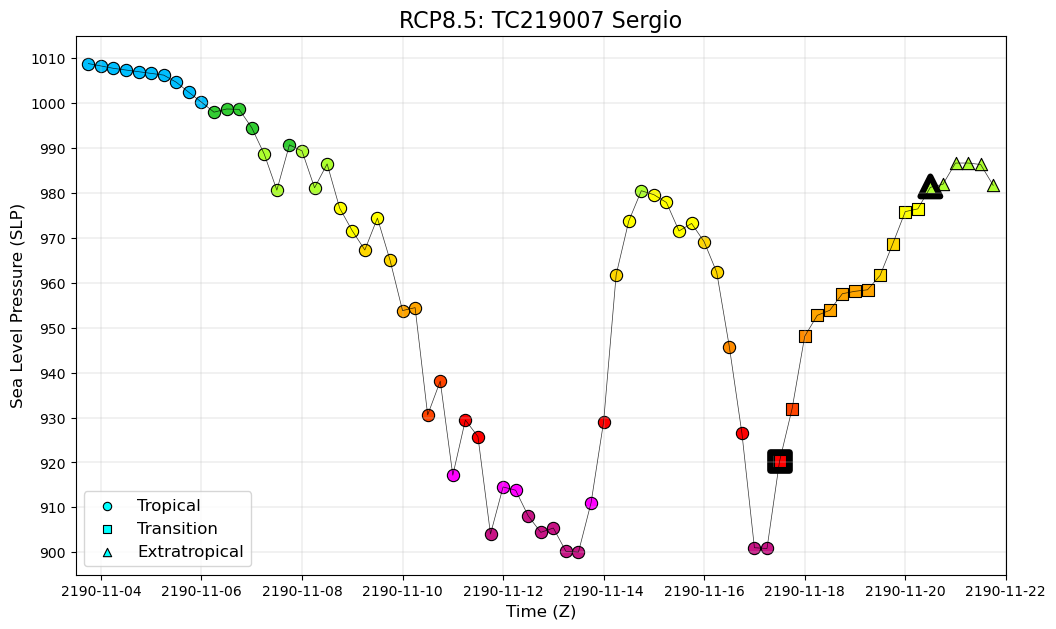

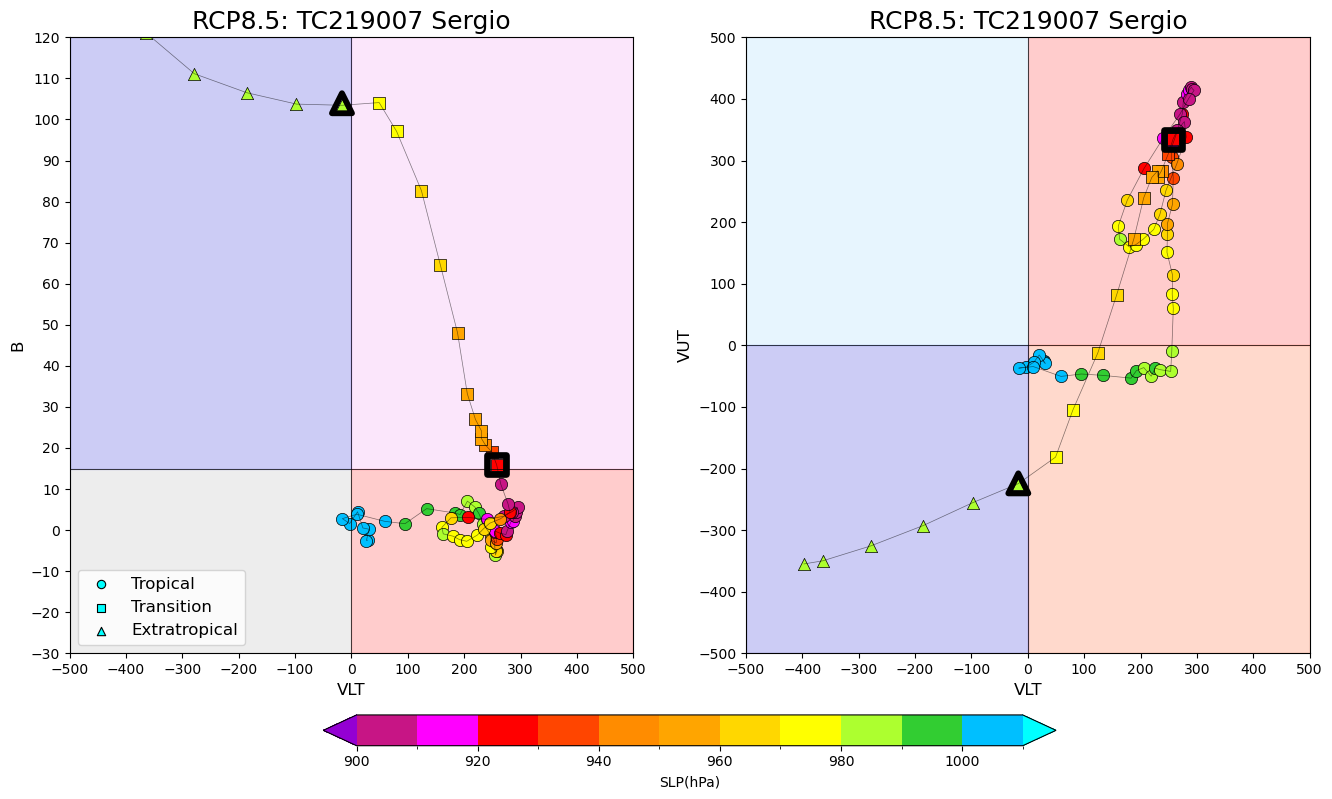

In [ ]:
# Input Code
Code = 'TC219007'
Plot_Cyclone_Track(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 2, True, "RCP8.5", True, (9,6))
Plot_Cyclone_SLP(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP8.5", True)
Plot_Cyclone_Phase(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP8.5", True)

In [ ]:
# Input Code
#Code = 'TC198413'
#Plot_Cyclone_Track(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 2, True, "Control", False, (7,7))
#Plot_Cyclone_SLP(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", False)
#Plot_Cyclone_Phase(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", False)

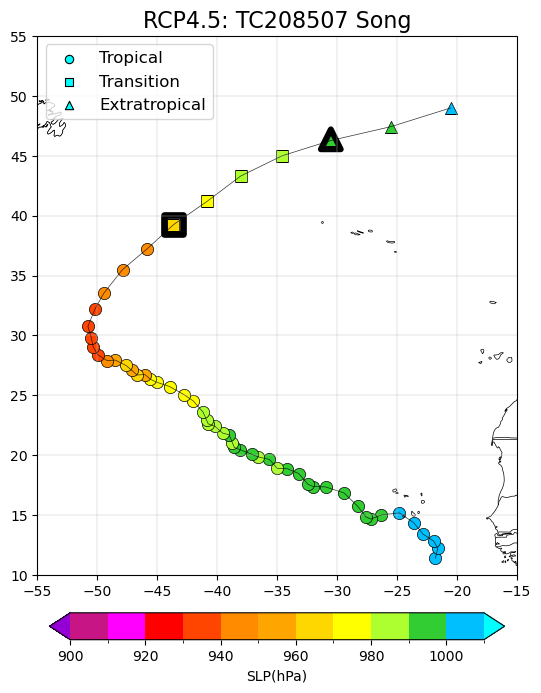

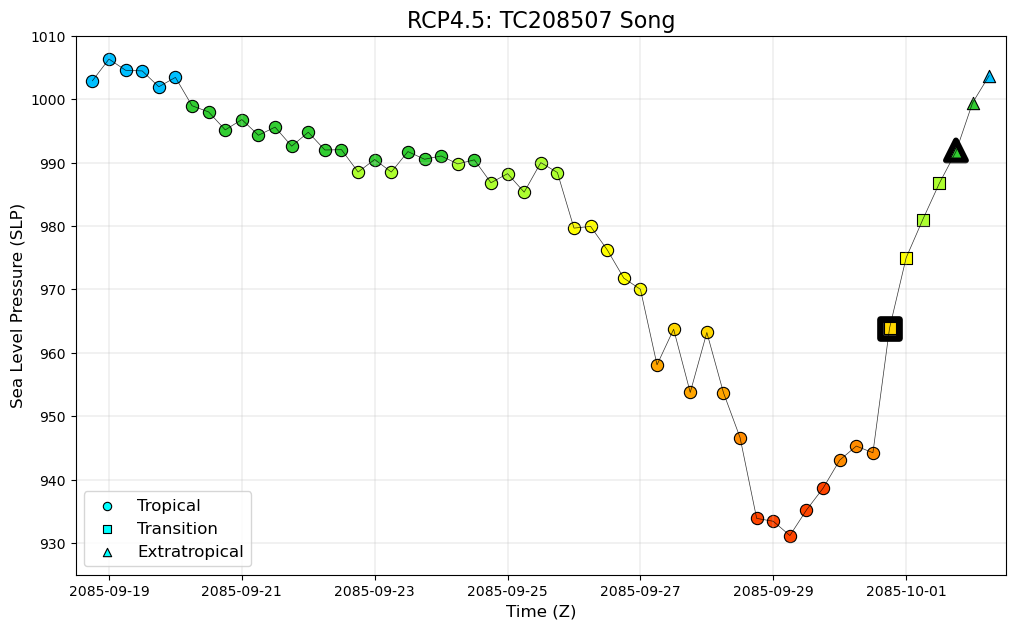

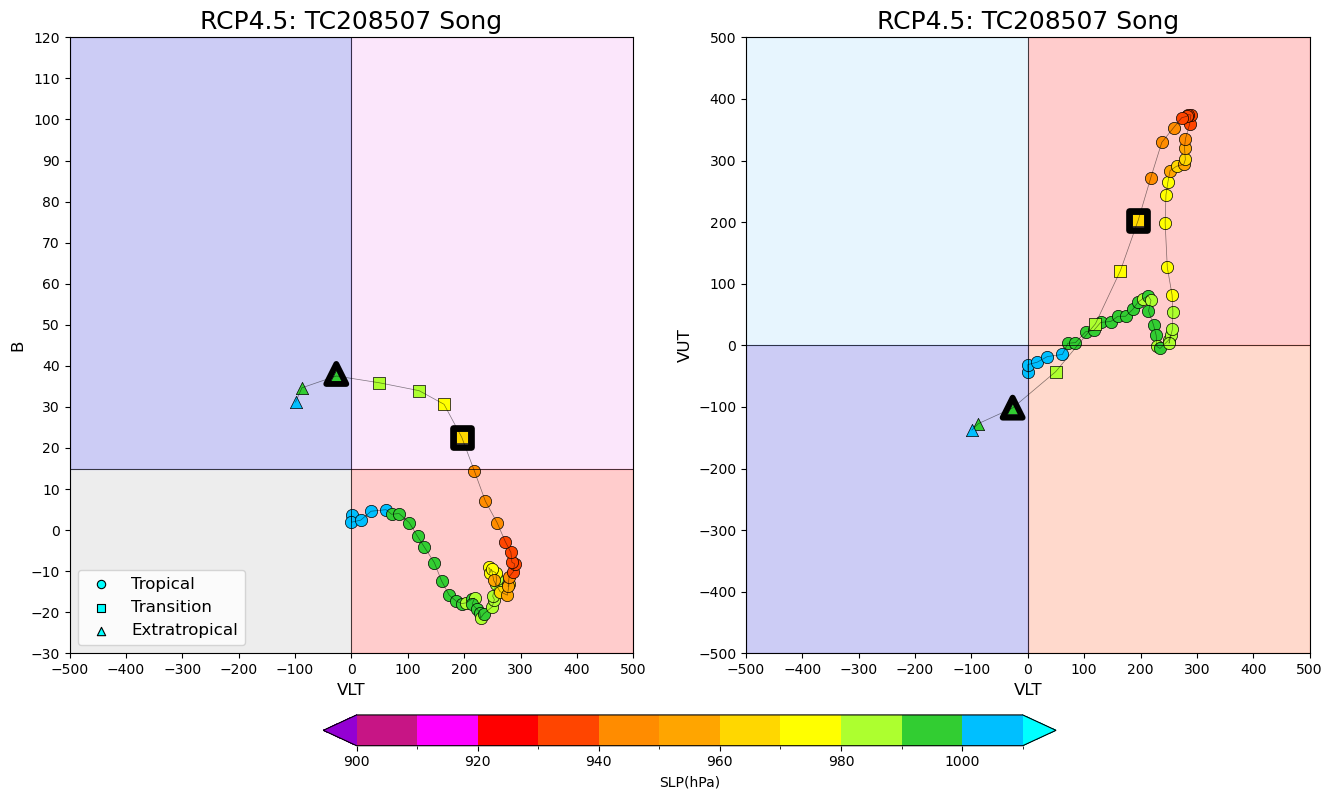

In [ ]:
# Input Code
Code = 'TC208507'
Plot_Cyclone_Track(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 2, True, "RCP4.5", False, (7,7))
Plot_Cyclone_SLP(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP4.5", False)
Plot_Cyclone_Phase(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP4.5", False)

In [ ]:
# Input Code
#Code = 'TC218405'
#Plot_Cyclone_Track(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 2, True, "RCP8.5", False, (7,7))
#Plot_Cyclone_SLP(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP8.5", False)
#Plot_Cyclone_Phase(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP8.5", False)

In [ ]:
# Input Code
#for i in range(len(Control_ET)):
#    Code = Control_ET["Code"][i]
#    if i >= 300 and i < 320:
#        Plot_Cyclone_Track(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 4, True, "Control", False, (7,7))
#        Plot_Cyclone_Phase(Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 3, True, "Control", False)

In [ ]:
# Input Code
#for i in range(len(RCP45_ET)):
#    Code = RCP45_ET["Code"][i]
#    if i >= 200 and i < 220:
#        Plot_Cyclone_Track(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 4, True, "RCP4.5", False, (7,7))
#        Plot_Cyclone_Phase(Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP4.5", False)

In [ ]:
# Input Code
#for i in range(len(RCP85_ET)):
#    Code = RCP85_ET["Code"][i]
#    if i >= 180 and i < 200:
#        Plot_Cyclone_Track(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 4, True, "RCP8.5", False, (7,7))
#        Plot_Cyclone_Phase(Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 3, True, "RCP8.5", False)

In [ ]:
Control_ET[Control_ET["Name"] == "Song"]

Code  Name  Path Type          Start Time            End Time  \
68   TC192010  Song          1 1920-10-28 06:00:00 1920-10-28 18:00:00   
236  TC196412  Song          1 1964-09-09 18:00:00 1964-09-11 18:00:00   

     Min SLP  Start SLP  End SLP  Start Lon  Start Lat  End Lon  End Lat  
68    975.57    1004.02  1006.47     -81.21      23.79   -79.47    24.67  
236   960.45     960.45   993.16     -47.21      39.94   -25.75    45.25

In [ ]:
RCP45_ET[RCP45_ET["Name"] == "Song"]

Code  Name  Path Type          Start Time            End Time  \
11   TC200507  Song          2 2005-08-15 12:00:00 2005-08-15 18:00:00   
60   TC202503  Song          1 2025-09-11 12:00:00 2025-09-16 06:00:00   
202  TC208507  Song          1 2085-09-30 18:00:00 2085-10-01 18:00:00   

     Min SLP  Start SLP  End SLP  Start Lon  Start Lat  End Lon  End Lat  
11    998.88    1010.88  1006.79     -67.43      36.64   -64.99    37.94  
60    941.01     947.84  1013.47     -56.33      38.85   -28.25    38.25  
202   931.18     963.87   991.71     -43.65      39.25   -30.51    46.28

In [ ]:
RCP85_ET[RCP85_ET["Name"] == "Song"]

Empty DataFrame
Columns: [Code, Name, Path Type, Start Time, End Time, Min SLP, Start SLP, End SLP, Start Lon, Start Lat, End Lon, End Lat]
Index: []